This notebooks uses the following dataset <br>
https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

# 1. Analysis of the Problem 

## Understand the problem

working hypothesis
think about model architecture
loss function
and loss criteria

select a measure of success
    Detect all classes/types of hand gestures with a high accuracy
    Classification Problem
    Check whether class-imbalanced problems

Dataset with class of the hand gesture/'Class' (our target value) the person which performed the hand gesture ('User') and a 
feature vector that consists 11 subvectors. Each subvector contains X, Y and Z coordinates. Those coordinates belong to one of the detected markes on the hand glove the user is wearing

* motion capture camera records 12 users performing 5 hand postures with markers attached to a left-handed glove
* rigid pattern of markers on the back of the glove -> establish local coordinate system for the hand
* 11 markers were attached to the thumb and fingers of the glove
* there is no a priori correspondence between the markers of two given records
* due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers.
    -> the number of visible markers in a record varied considerably.


The Problem:
We cannot easily apply traditional approaches because of two properties of point clouds:
* unordered collection (Point 1 with X,Y and Z coordinates could refer to the thh )
* the size of the point cloud varies (due to occlusion, etc.)

## Useful Information from the authors/paper

Class label:<br>
1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab)


Preprocessing:<br>
all markers were transformed to the local coordinate system of the record containing them.

Reduce number of records:<br>
each transformed marker with a norm greater than 200 millimeters was pruned. 
records that contained fewer than 3 markers was removed. 
the data has at most 12 markers per record and at least 3

Be careful:<br>
It is likely that for a given record and user there exists a near duplicate record originating from the same user.
-> evaluate on leave-one-user-out basis wherein

## Ideas I want to try out


**My goal**

* able to predict which gesture a person is performing

* achieve a high accuracy

**My idea/approach**

* 1.approach: extract features that are meaningful for a given data point, train conventional models

* 2.approach: use models that are adapted to point clouds and have been developed specifically for this data

# 2. Data Exploration and Preparation

Check for missing values, NaN values or features,
uniqueness of the data (is it as it was expected to be)
understand the variations in the data (statistical tools)
outliers?
Is it possible to combine features?
Do you have unnecessary features? (a column which gives no information – for instance name
column– or a feature you consider unrelated to the problem)
Check the correlation matrix. It will tell you how much the features are related. You may say,
for instance, there is a great potential to reduce number of dimensions.
scale data (for example, in the [-1, 1] range).

## Preparing the enviroment

In [1]:
#%reload_ext autoreload
#%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import time
import pickle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers
from typing import Tuple, Optional, Callable
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# My custom functions
from scripts import analyze_helper, visualisation

# Utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, average_precision_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from os.path import dirname, abspath, join

# Models we want to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

2023-03-10 18:04:51.827062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 18:04:51.958750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/Documents/seam_eng/group4_ws/devel/lib:/opt/ros/noetic/lib
2023-03-10 18:04:51.958779: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 18:04:52.610023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; d

## Write utility functions I want to use multiple times

In [2]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred):

    plt.clf()

    class_labels = ['Fist', 'Stop', 'Point1', 'Point2', 'Grab']
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
    
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    #normalize
    cf_matrix = (cf_matrix.T/cf_matrix.sum(axis=1)).T
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    custom_cmap = sns.light_palette("#009682", as_cmap=True)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=custom_cmap, xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [3]:
class Report:

    report: dict

    def __init__(self, model_name:str, model, X_test, y_test, description:list=[]):
        self.X_test = X_test
        self.y_test = y_test
        self.description = description
        self.model_name = model_name

        self.report = self.create_report(model)


    def create_report(self, model):

        try:
            if type(model) == keras.Sequential:
                y_score = model.predict(self.X_test)
            else:
                y_score = model.predict_proba(self.X_test)
        except AttributeError:
            print('No report possible, because no predict_proba method')
            report = None
            return
        y_score_2 = model.predict(self.X_test)
        print(y_score.shape)
        print(y_score_2.shape)
        print(self.y_test.shape)
        print(self.y_test)
        if type(model) != keras.Sequential:
            report = classification_report(self.y_test, y_score_2, output_dict=True)
        else:
            y_score_2 = to_categorical(np.argmax(y_score_2, axis=1))
            print(y_score_2.shape)
            print(self.y_test.shape)
            report = classification_report(self.y_test, y_score_2, output_dict=True)
            #NN report does not have accuracy score -> have a look why
            accuracy = accuracy_score(self.y_test, y_score_2)
            report['accuracy'] = accuracy

        return report
    
    def get_report_as_df(self, df_to_save_to:pd.DataFrame):
        'Get the report as a dataframe'

        print(self.report)

        new_row = {'model': self.model_name,
                   'Accuracy': round(self.report["accuracy"],6), 
                   'Precision': round(self.report["macro avg"]["precision"],5),
                   'Recall': round(self.report["macro avg"]["recall"],6),
                   'F1_score': round(self.report["macro avg"]["f1-score"],6)} 
        df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)

        return df_to_save_to


    def __str__(self):

        if self.report is None:
            print('No return possbile')
            return 'No valid return'

        pattern = '''
        ***********************REPORT*******************************
        Average (macro) precision: {}
        Average accuracy: {}
        Average (macro) recall: {}
        Average (macro) f1-score: {}
        Description {}
        ************************************************************
        '''
        return pattern.format(round(self.report["macro avg"]["precision"],5), round(self.report["accuracy"],6), round(self.report["macro avg"]["recall"],6), round(self.report["macro avg"]["f1-score"],6), ', '.join(self.description))

In [4]:
def save_eval_dict_pkl(eval_dict, name):

    # Get path to save the history
    eval_folder = 'model/single_run/eval'
    model_path = join(eval_folder, name)
    
    with open(model_path, 'wb') as file_pi:
        pickle.dump(eval_dict, file_pi)

def load_eval_dict_pkl(name) -> dict:

    # Get path to save the history
    eval_folder = 'model/single_run/eval'
    model_path = join(eval_folder, name)

    with open(model_path, 'rb') as file_pi:
        eval_dict = pickle.load(file_pi)
    
    return eval_dict

def save_to_eval_dict(eval_dict:dict, split_set:str, acc:float, precission:float, recall:float, f1:float):
    ''' Save multiple metrics to a dictionary for evaluation '''

    if split_set not in ['train', 'test']:
        raise ValueError('split_set must be either train or test')
    
    eval_dict[split_set]['accuracy'].append(acc)
    eval_dict[split_set]['precision'].append(precission)
    eval_dict[split_set]['recall'].append(recall)
    eval_dict[split_set]['f1'].append(f1)

    return eval_dict

In [5]:
def plot_eval_dict_barplot_new(data):

    # Extracting data
    train_acc = data['train']['accuracy']
    train_prec = data['train']['precision']
    train_recall = data['train']['recall']
    train_f1 = data['train']['f1']
    test_acc = data['test']['accuracy']
    test_prec = data['test']['precision']
    test_recall = data['test']['recall']
    test_f1 = data['test']['f1']

    # Creating subplots for accuracy and precision
    fig, axs = plt.subplots(2, 2, figsize=(15, 5))
    bar_width = 0.2

    # Plot for accuracy
    axs[0][0].bar([i+bar_width/2 for i in range(len(train_acc))], train_acc, width=bar_width, color='b', label='Train Accuracy')
    axs[0][0].bar([i-bar_width/2 for i in range(len(test_acc))], test_acc, width=bar_width, color='r', label='Test Accuracy')
    axs[0][0].set_xticks(range(len(train_acc)))
    axs[0][0].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[0][0].set_ylabel('Accuracy')
    axs[0][0].set_title('Accuracy')
    axs[0][0].legend()

    # Plot for precision
    axs[0][1].bar([i+bar_width/2 for i in range(len(train_prec))], train_prec, width=bar_width, color='b', label='Train Precision')
    axs[0][1].bar([i-bar_width/2 for i in range(len(test_prec))], test_prec, width=bar_width, color='r', label='Test Precision')
    axs[0][1].set_xticks(range(len(train_acc)))
    axs[0][1].set_xticklabels([f'CV{i}' for i in range(len(train_acc))])
    axs[0][1].set_ylabel('Precision')
    axs[0][1].set_title('Precision')
    axs[0][1].legend()

    # Plot for recall
    axs[1][0].bar([i+bar_width/2 for i in range(len(train_recall))], train_recall, width=bar_width, color='b', label='Train Recall')
    axs[1][0].bar([i-bar_width/2 for i in range(len(test_recall))], test_recall, width=bar_width, color='r', label='Test Recall')
    axs[1][0].set_xticks(range(len(train_recall)))
    axs[1][0].set_xticklabels([f'CV{i}' for i in range(len(train_recall))])
    axs[1][0].set_ylabel('Recall')
    axs[1][0].set_title('Recall')
    axs[1][0].legend()

    # Plot for f1_score
    axs[1][1].bar([i+bar_width/2 for i in range(len(train_f1))], train_f1, width=bar_width, color='b', label='Train F1-Score')
    axs[1][1].bar([i-bar_width/2 for i in range(len(test_f1))], test_f1, width=bar_width, color='r', label='Test F1-Score')
    axs[1][1].set_xticks(range(len(train_f1)))
    axs[1][1].set_xticklabels([f'CV{i}' for i in range(len(train_f1))])
    axs[1][1].set_ylabel('F1 Score')
    axs[1][1].set_title('F1 Score')
    axs[1][1].legend()

    plt.show()

## Loading the Data

In [6]:
file_path_raw = os.path.join('data', 'Postures.csv')
df_raw = pd.read_csv(file_path_raw, sep=',', na_values='?')

## Understand the Data

### Choose a metric

To choose a metric we have to check whether the classes are balenced/unbalanced

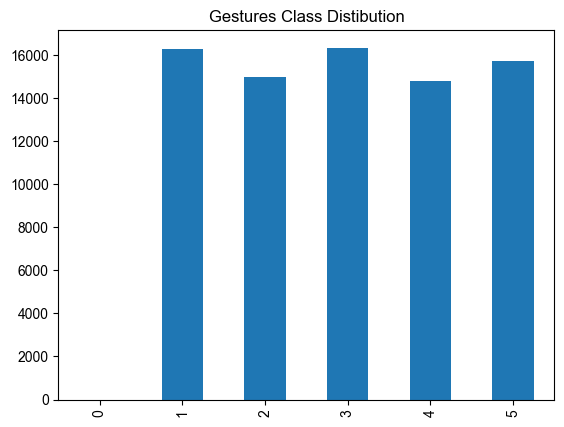

In [7]:
class_counts = df_raw['Class'].value_counts(sort=False)
class_counts.plot(kind='bar', title='Gestures Class Distibution')
plt.show()

To jugde the model perfomance we will choose a mixture of multiple metrics:
* Confusion Matrix
* Accuracy (we have balanced classes!)
* Recall (made TP predictions divided by possible TP predictions)
* precission-recall plot
* F1-Score (harmonic mean between recall and precision, combines the two metrics into one value)

TODO 
Maybe Later
* ROC AUC (Receiver Operator Characteristic — Area Under the Curve, we want a high TPR with a low FPR)
Note: we will use the One vs Rest strategy for ROC AUC (because it is usally a metric for binary classification)

Write utility function to use the ROC AUC for multiclass classficiation

In [8]:
def precision_recall_multiclass(model, X_test, y_test):

    plt.clf()

    y_score = model.predict_proba(X_test)
    y_score_2 = model.predict(X_test)
    
    #print('Amount and Distribution of Test Data: \n', y_test.value_counts())
    y_bin = pp.label_binarize(y_test, classes=model.classes_)

    precision = dict()
    recall = dict()
    average_precision = dict()
    classes = model.classes_

    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
        #print('\n average precision: ', classes[i], ': ', average_precision[i])
        try:
            plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))
        except Exception as e:
            print(e)

    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

## Data Exploration

In [9]:
df_raw.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10',
       'Z10', 'X11', 'Y11', 'Z11'],
      dtype='object')

In [10]:
# Check which columns have missing values
print(f"Missing values in: {analyze_helper.check_for_missing_vals(df_raw)}")
# Compute missing ratio, hide columns with no missing values (0.0%)
analyze_helper.compute_missing_ratio(df_raw)

Missing values in: ['X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11']


X3      0.88
Y3      0.88
Z3      0.88
X4      4.00
Y4      4.00
Z4      4.00
X5     16.68
Y5     16.68
Z5     16.68
X6     33.10
Y6     33.10
Z6     33.10
X7     50.13
Y7     50.13
Z7     50.13
X8     60.86
Y8     60.86
Z8     60.86
X9     69.31
Y9     69.31
Z9     69.31
X10    81.11
Y10    81.11
Z10    81.11
X11    99.96
Y11    99.96
Z11    99.96
Name: percent_missing, dtype: float64

Hint 1 for preprocessing:
drop the coordinates (X,Y,Z) for point 10 and 11

In [11]:
df_raw = df_raw.fillna(0)

In [12]:
df_raw.head(5)
df_raw.drop([0], inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [13]:
print('Number of Instances  : ', df_raw.shape[0])
print('Number of Attributes : ', df_raw.shape[1])
print('Number of target classes   : ', df_raw['Class'].nunique()-1)
print('Number of users   : ', df_raw['User'].nunique())

Number of Instances  :  78095
Number of Attributes :  38
Number of target classes   :  4
Number of users   :  14


The description says the data set contains 12 User. No information provided (why are 14 user in the data?).
Hint for us to drop User 4 and 7 ?
They both have signifiantly less data points

In [14]:
user_group = df_raw.groupby(['User'], sort=False)
user_group.count()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
User,,,,,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,...,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,...,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,...,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
4,379,379,379,379,379,379,379,379,379,379,...,379,379,379,379,379,379,379,379,379,379
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,...,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,...,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
7,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,...,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,...,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920


In [15]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78095 entries, 0 to 78094
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78095 non-null  int64  
 1   User    78095 non-null  int64  
 2   X0      78095 non-null  float64
 3   Y0      78095 non-null  float64
 4   Z0      78095 non-null  float64
 5   X1      78095 non-null  float64
 6   Y1      78095 non-null  float64
 7   Z1      78095 non-null  float64
 8   X2      78095 non-null  float64
 9   Y2      78095 non-null  float64
 10  Z2      78095 non-null  float64
 11  X3      78095 non-null  float64
 12  Y3      78095 non-null  float64
 13  Z3      78095 non-null  float64
 14  X4      78095 non-null  float64
 15  Y4      78095 non-null  float64
 16  Z4      78095 non-null  float64
 17  X5      78095 non-null  float64
 18  Y5      78095 non-null  float64
 19  Z5      78095 non-null  float64
 20  X6      78095 non-null  float64
 21  Y6      78095 non-null  float64
 22

### Data Visualization

In [16]:
def pltHand(handPoints):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for i in range(11):
        pntx = f'X{i}'
        pnty = f'Y{i}'
        pntz = f'Z{i}'
        
        if(handPoints[pntx].values[0] == 0 or
            handPoints[pnty].values[0] == 0 or
            handPoints[pntz].values[0] == 0):
            n = 0;
        else:
            xlocation = handPoints[pntx]
            ylocation = handPoints[pnty]
            zlocation = handPoints[pntz]
            ax.scatter(xlocation, ylocation, zlocation, marker='v')
    
    crntClass = handPoints['Class'].values[0]
    if (crntClass == 1):
        title = 'Fist + Thumb out'
    if(crntClass == 2):
        title = 'Stop/Flat hand'
    if (crntClass == 3):
        title = 'Point with pointer finger'
    if (crntClass == 4):
        title = 'Point with pointer + middle finger'
    if (crntClass == 5):
        title = 'Grab'
    
    plt.title(title)
    plt.show()


In [17]:
#TODO create a rotateable 3D plot

In [18]:
# Plot a random hand gesture from the dataset to get a an idea of the data
#TODO not working on linux, check why
'''
for _ in range(4):
    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]
    pltHand(df_raw[rand_dp:rand_dp+1] )
'''

'\nfor _ in range(4):\n    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]\n    pltHand(df_raw[rand_dp:rand_dp+1] )\n'

In [19]:
def correlation_matrix(df: pd.DataFrame):

    correlationMatrix = pd.DataFrame(df_raw).corr() 
    f = plt.figure(figsize=(12, 6))
    plt.matshow(correlationMatrix, fignum=f.number)
    plt.xticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14, rotation=75)
    plt.yticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

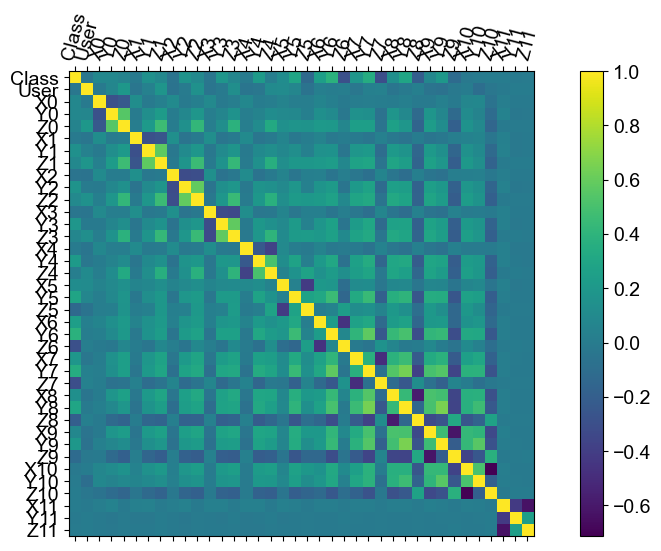

In [20]:
correlation_matrix(df_raw)

## Pre-processing



### General

In [21]:
# Drop rows of user 4 and 7
# Because they have significantly less data points
df_raw = df_raw[df_raw['User'] != 4]
df_raw = df_raw[df_raw['User'] != 7]
df_raw.reset_index(drop=True, inplace=True)

In [22]:
# Drop coordinates of point 10 and 11
# More than 90% of the data is missing
# Search for "Hint 1" for further information
df_raw.drop(['X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11'], inplace=True, axis=1)

### PCA

In [23]:
# TODO compute PCA and plot the data

### Preparing Dataset

### a. Extract features (min, max, mean, etc.) - df_aggregate

Ideas for new features: (inspired from paper)<br>
* number of markers
* mean (per coordinate)
* Eigenvalues and vectors of the points covariance matrix
https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give
* dimensions of the axis-aligned minimum bounding box centered on the mean

Keep in mind that each feature has to aggregate the points in such a way that the result is order invariant!


In [24]:
# New data set we want to fill step by step
df_aggregate= pd.DataFrame()
# We dont want to change the original data set
df_raw_dummy = df_raw.copy(deep=True)

# Save the user and class column
df_user = df_raw_dummy.pop('User')
df_class = df_raw_dummy.pop('Class')


In [25]:
# Extract the X, Y and Z columns
df_x = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('X')]]
df_y = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Y')]]
df_z = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Z')]]

In [26]:
# Extract the mean of the X, Y and Z columns
for coordinate in ['X', 'Y', 'Z']:
    df_aggregate[f'{coordinate}_mean'] = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith(coordinate)]].mean(axis=1)

In [27]:
# Extract the number of visible points (not occluded)
df_aggregate['n_points'] = (df_raw_dummy.astype(bool).sum(axis=1))/3
df_aggregate

,X_mean,Y_mean,Z_mean,n_points
0,31.220158,27.403799,-33.548944,5.0
1,32.392560,27.823996,-32.104566,5.0
2,32.081207,27.936918,-32.385520,5.0
3,31.719552,27.575915,-32.964177,5.0
4,31.594851,27.416170,-33.195235,5.0
...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0
77220,28.021968,97.191781,-29.248339,10.0
77221,28.103645,96.953570,-29.735080,10.0
77222,20.384035,93.649845,-25.356364,9.0


In [28]:
df_raw_dummy

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.232264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.450873,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.835388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.596157,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.368748,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,-46.460186,-1.901940,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,-17.002723,-22.743924,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,-53.939140,-30.225675,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,-17.460853,26.715915,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


My idea:<br>
find the orientation of a given cluster<br>
(https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give)

1. Rearange the dataset (1 point per row with X, Y, Z value)
-> All points per row will be saved in a batch as new sub dataframe
2. Compute the covariance matrix for each sub dataframe
3. Calculate the Eigenvalues and Eigenvectors of the covariance matrix
4. Concat created features to the dataframe


DISCLAIMER: <br>
The following function can take up to 1 min!

In [29]:

# Assume you have a DataFrame called 'df' with the columns ['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
# Reorganize the dataframe to have each row as a batch of data
# 'X0', 'Y0', 'Z0',
# 'X1', 'Y1', 'Z1',
# 'X2', 'Y2', 'Z2'

# Create an empty list to store the batches of data
batches = []

# Iterate over the DataFrame and extract the batches of data
for row in range(0, df_raw_dummy.shape[0]):

    col_batch = []
    # Extract a batch of data for the current row
    for col in range(0, df_raw_dummy.shape[1], 3):
        batch = df_raw_dummy.iloc[row, col:col+3]
        # Rename the columns
        batch.index = ['X', 'Y', 'Z']
        #print(f'batch: {batch}')
        col_batch.append(batch)
    # Append the batch to the list
    batches.append(col_batch)

# Concatenate the batches of data under each other
concat_batches = []
for batch in batches:
    concat_batch = pd.concat(batch, axis=1).transpose()
    concat_batches.append(concat_batch)
    # Remove rows with all zeros
    concat_batch = concat_batch[(concat_batch.T != 0).any()]

# Create a dictionary with the eigenvalues and eigenvectors as values
eigen_dict = {'eigenvec_1_1': [],
                'eigenvec_1_2': [],
                'eigenvec_1_3': [],
                'eigenvec_2_1': [],
                'eigenvec_2_2': [],
                'eigenvec_2_3': [],
                'eigenvec_3_1': [],
                'eigenvec_3_2': [],
                'eigenvec_3_3': [],
              'eigenval_1': [],
              'eigenval_2': [],
              'eigenval_3': []}

# Create the DataFrame
eigen_df = pd.DataFrame(eigen_dict)

# Compute the covariance matrix for each batch
for concat_batch in concat_batches:
    # Compute the covariance matrix
    cov_matrix = np.cov(concat_batch, rowvar=False)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Add the eigenvalues and eigenvectors to the DataFrame
    # Store eigenvector 1
    eigen_dict['eigenvec_1_1'].append(eigenvectors[0, 0])
    eigen_dict['eigenvec_1_2'].append(eigenvectors[1, 0])
    eigen_dict['eigenvec_1_3'].append(eigenvectors[2, 0])
    # Store eigenvector 2
    eigen_dict['eigenvec_2_1'].append(eigenvectors[0, 1])
    eigen_dict['eigenvec_2_2'].append(eigenvectors[1, 1])
    eigen_dict['eigenvec_2_3'].append(eigenvectors[2, 1])
    # Store eigenvector 3
    eigen_dict['eigenvec_3_1'].append(eigenvectors[0, 2])
    eigen_dict['eigenvec_3_2'].append(eigenvectors[1, 2])
    eigen_dict['eigenvec_3_3'].append(eigenvectors[2, 2])
    # Store eigenvalues
    eigen_dict['eigenval_1'].append(eigenvalues[0])
    eigen_dict['eigenval_2'].append(eigenvalues[1])
    eigen_dict['eigenval_3'].append(eigenvalues[2])

# Finally add generated features to the DataFrame
df_aggregate = pd.concat([df_aggregate, pd.DataFrame(eigen_dict)], axis=1)

In [30]:
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364


In [31]:
# Add user and class information to the new data set after the feature extraction
df_aggregate['User'] = df_user
df_aggregate['Class'] = df_class

**Evaluation Strategy**:<br>
We will use a k-Fold cross-validation to evaluate our model <br>
We randomly choose 2 User for the test set <br>
Then we remove the users from the selectable list so that each user is in the test data set at most once over all k runs <br>
For the next split we again choose 2 random User, and so on<br>

In [32]:
import random

def get_train_test_user(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''This function returns the indices for the training and test set.
    The function randomly selects two users for the test set and the remaining
    users for the training set.
    
    return: train_indices, test_indices'''

    # Create a list of indices for the training and test set
    train_indices = []
    test_indices = []
    
    # Generate 2 random numbers between 0 and 14
    test_user_1, test_user_2 = random.sample(user_list, num_user_test)
    print(f'User picked for test set: {test_user_1}, {test_user_2}')
    

    # Iterate over the users
    for user in user_list:
        # Get the indices for the current user
        indices = df[df['User'] == user].index
        # Append the indices to the list
        if user == test_user_1 or user == test_user_2:
            test_indices.extend(indices)
        else:
            train_indices.extend(indices)
    
    # Remove the test users from the user list so they cannot be selected again
    user_list = [x for x in user_list if x != test_user_1 and x != test_user_2]

    return train_indices, test_indices, user_list

def custom_cv_approach(df:pd.DataFrame, user_list:list, num_user_test:int=2):
    '''
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''
    def cv_ratio(y_test, df):
        print(f'Ratio of test set: {len(y_test)/len(df)}')
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    # Create the training and test set
    X_train = df.iloc[train_indices, :]
    y_train = X_train.pop('Class')
    X_train.pop('User')
    X_test = df.iloc[test_indices, :]
    y_test = X_test.pop('Class')
    X_test.pop('User')

    # Print the ratio of the test set
    cv_ratio(y_test, df)

    return X_train, y_train, X_test, y_test, user_list



In [33]:
user_group = df_aggregate.groupby(['User'], sort=False)
user_group.count()

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,Class
User,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920
10,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573
11,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061


In [34]:
#TODO add augmentation to the data set.
# e.g. add Jitter or Shuffle data

### c.I Split data - Wrong way

#### Demonstration data set (WRONG WAY) - mixed user

******************************************************
DEMONSTRATION: this shows how NOT to do it:<br>
Splitting the naive way (similar data points will be in both sets)
******************************************************

In [35]:
df_raw

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9
0,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-17.150292,-22.833830,104.593913,-53.126136,61.494952,101.205748,-6.543115,87.733364,61.216363,-62.126278
77220,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,4.248334,61.390015,101.468284,-5.985371,88.177233,60.780642,-62.130563,78.229847,33.078407,-45.249543
77221,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,-46.796054,88.291029,60.362768,-62.718735,-1.779495,98.089459,3.835904,78.591554,32.327738,-46.166556
77222,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,-43.967820,-1.581415,98.017411,3.394291,88.465709,60.050791,-63.221626,0.000000,0.000000,0.000000


In [36]:

# Split the data into train and test set
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(df_raw, df_raw['Class'], test_size=0.25)
user_group = df_raw.groupby(['User'], sort=False)

We normalize the data using a Min-Max-Scaler

In [37]:
# Normalize the data with MinMaxScaler

# Create the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train_mixed)

# Transform the training and test data
X_train_mixed = scaler.transform(X_train_mixed)
X_test_mixed = scaler.transform(X_test_mixed)

#### c.II Split data properly (but still on raw data set)


We now have a CV loop:
I split the data in the same loop, where I train the model for a specific k-fold <br>
Therefore I dont split the data beforehand in this section

# 1. Testing Phase I: Baseline Models

After we have trained all the models, we want to compare the model performance using selected metrics. Therefore we need to save the metrics

In [38]:
df_results = pd.DataFrame(columns=['model', 'Accuracy', 'Precision', 'Recall', 'F1_score'])

First, we write a training function to have a common interface for all conventional machine learning models.

In [39]:
def train_model(df:pd.DataFrame, model_func: Callable, scaler_choice:str, kwargs_dict:dict):
    '''This function provides a common interface to train the classic ml models.
    In a loop we iterate over different train and test sets and train the model.
    We leave out k users from the data set and use them as test set.
    '''

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    # Save evaluation metrics in a dictionary
    eval_dict = {'train': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []},
                    'test': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []}}

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        model = model_func(**kwargs_dict)

        # Split the data
        X_train, y_train, X_test, y_test, user_list = custom_cv_approach(df, user_list, num_user_test=num_user_test)

        if scaler_choice == 'normalize':
            # Normalize the data
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        elif scaler_choice == 'standard':
            # Standard Scale the data
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            print('No scaling applied')

        # Fit the model
        model.fit(X_train, y_train)
        model_acc = model.score(X_test, y_test)
        
        # Print the results
        print('Train accuracy: ', model.score(X_train, y_train))
        print('(CV-) Test accuracy: ', model_acc)

        # Save the results
        y_pred_train = model.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_precision = precision_score(y_train, y_pred_train, average='macro')
        train_recall = recall_score(y_train, y_pred_train, average='macro')
        f1_score_train = f1_score(y_train, y_pred_train, average='macro')
        eval_dict = save_to_eval_dict(eval_dict, 'train', train_acc, train_precision, train_recall, f1_score_train)

        y_pred_test = model.predict(X_test)
        val_acc = accuracy_score(y_test, y_pred_test)
        val_precision = precision_score(y_test, y_pred_test, average='macro')
        val_recall = recall_score(y_test, y_pred_test, average='macro')
        f1_score_test = f1_score(y_test, y_pred_test, average='macro')

        eval_dict = save_to_eval_dict(eval_dict, 'test', val_acc, val_precision, val_recall, f1_score_test)

        # Save best model
        if model_acc > best_acc:
            best_model = model
            best_acc = model_acc
            X_test_best = X_test
            y_test_best = y_test

    return best_model, X_test_best, y_test_best, eval_dict


## Random Forest Classifier

In [40]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
#-----------------------------------------------------------------
# Number of trees in the forest:
n_estimators = 100 # default
# Number of features to consider when looking for the best split:
max_features = 'auto'
# Maximum depth of the tree:
max_depth = None
# Minimum number of samples required to split an internal node:
min_samples_split = 2
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2023
#-----------------------------------------------------------------


In [41]:
def plot_feature_importance_rf(rfc_model:RandomForestClassifier, feature_names:list):
    '''
    This function plots the feature importance of the random forest classifier.

    Parameters:
        rfc_model: Random Forest Classifier model
        X_train: Training data set, only for the feature names

    '''

    feature_importance = np.array(rfc_model.feature_importances_)
    feature_names = np.array(feature_names)

    data={'Feature names':feature_names,'Feature importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['Feature importance'], ascending=False,inplace=True)

    plt.clf()
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['Feature importance'], y=fi_df['Feature names'])
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Feature Importance')

    plt.show()

### a) Mixed dataset (wrong way)

In [42]:
# Creating the classifier:
RFC_demo = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)
RFC_demo.fit(X_train_mixed, y_train_mixed)
RFC_demo.score(X_test_mixed, y_test_mixed)

0.9999482026313063

(19306, 5)
(19306,)
(19306,)
33263    5
60322    5
30849    3
31566    3
7135     5
        ..
3567     3
68163    4
61954    1
31618    3
63830    2
Name: Class, Length: 19306, dtype: int64

        ***********************REPORT*******************************
        Average (macro) precision: 0.99995
        Average accuracy: 0.999948
        Average (macro) recall: 0.99995
        Average (macro) f1-score: 0.999948
        Description mixed_data, raw features
        ************************************************************
        


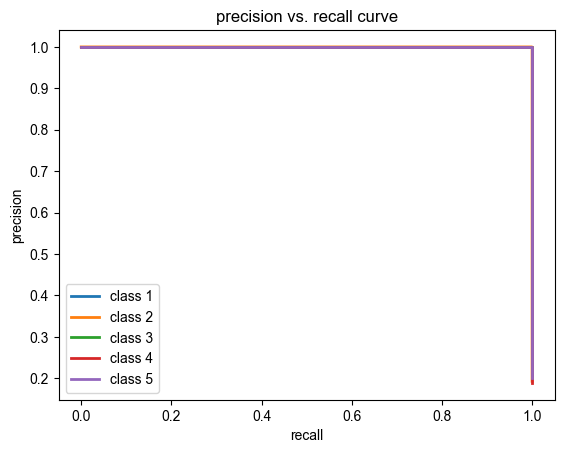

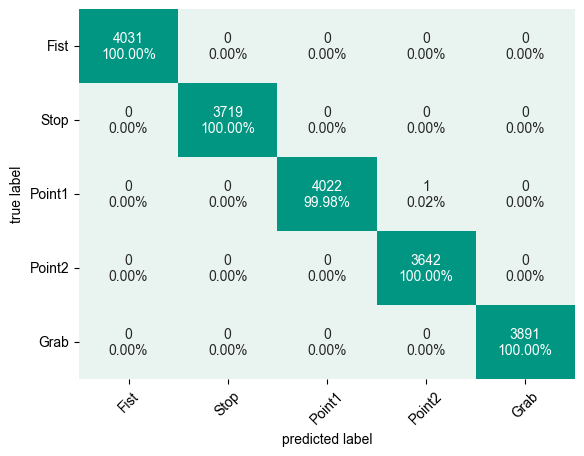

In [43]:
mixed_data_report = Report('rfc_mixed', RFC_demo, X_test_mixed, y_test_mixed, description=['mixed_data', 'raw features'])
print(mixed_data_report)
precision_recall_multiclass(RFC_demo, X_test_mixed, y_test_mixed)
y_pred_mixed = RFC_demo.predict(X_test_mixed)
plot_cm(y_test_mixed, y_pred_mixed)

Too good to be true...<br>
This was a demonstration how we should not split the data set!
Many people on kaggel etc. made this mistake

From now on we will not use this (wrong) processed data set

### b) Custom CV - with raw data

In [44]:
# Hyperparameters:
#Random Forest raw features
rf_raw_hyperparams = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'bootstrap': bootstrap,
                'oob_score': oob_score,
                'n_jobs': n_jobs,
                'random_state': random_state}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_raw, RandomForestClassifier, 'normalize', rf_raw_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 2, 8
Ratio of test set: 0.1466383507717808


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.7887672200635818
**************************************************
CV Run: 1
User picked for test set: 12, 6
Ratio of test set: 0.11967782036672538


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.7860852629301017
**************************************************
CV Run: 2
User picked for test set: 5, 9
Ratio of test set: 0.11686781311509375


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.5586703601108033
**************************************************
CV Run: 3
User picked for test set: 0, 14
Ratio of test set: 0.2142209675748472


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.6534485885268694


In [45]:
eval_dict

{'train': {'accuracy': [1.0, 1.0, 1.0, 1.0],
  'precision': [1.0, 1.0, 1.0, 1.0],
  'recall': [1.0, 1.0, 1.0, 1.0],
  'f1': [1.0, 1.0, 1.0, 1.0]},
 'test': {'accuracy': [0.7887672200635818,
   0.7860852629301017,
   0.5586703601108033,
   0.6534485885268694],
  'precision': [0.8182755464787166,
   0.8820383121842845,
   0.6113373797941064,
   0.7038977337325795],
  'recall': [0.8130790057532788,
   0.7775483495536245,
   0.5586219161611625,
   0.6545674748956763],
  'f1': [0.7522512223131533,
   0.7813742789987961,
   0.5472205461648644,
   0.6505218680621732]}}

#### Evaluation

(11324, 5)
(11324,)
(11324,)
13765    1
13766    1
13767    1
13768    1
13769    1
        ..
34566    5
34567    5
34568    5
34569    5
34570    5
Name: Class, Length: 11324, dtype: int64
{'1': {'precision': 0.9567246499787866, 'recall': 0.9825708061002179, 'f1-score': 0.9694754944110061, 'support': 2295}, '2': {'precision': 0.6340388007054674, 'recall': 0.9804545454545455, 'f1-score': 0.7700821135308819, 'support': 2200}, '3': {'precision': 0.8372260150916278, 'recall': 0.9744876620660812, 'f1-score': 0.9006571318129107, 'support': 2391}, '4': {'precision': 0.7660668380462725, 'recall': 0.9733260751224823, 'f1-score': 0.8573483577079837, 'support': 1837}, '5': {'precision': 0.8973214285714286, 'recall': 0.15455594002306805, 'f1-score': 0.2636930141029846, 'support': 2601}, 'accuracy': 0.7887672200635818, 'macro avg': {'precision': 0.8182755464787166, 'recall': 0.8130790057532788, 'f1-score': 0.7522512223131533, 'support': 11324}, 'weighted avg': {'precision': 0.8242293935484559, 'r

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


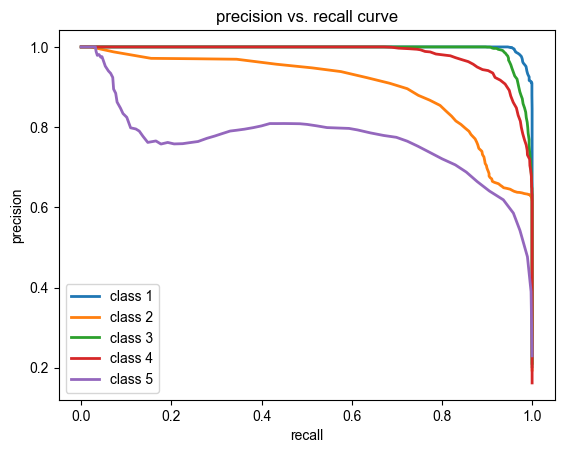

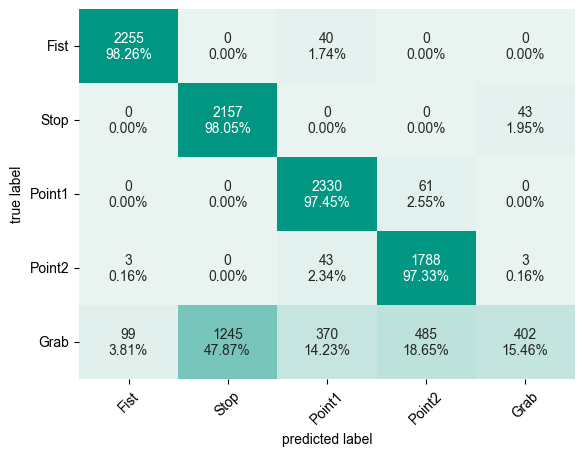

In [46]:
raw_w_cv_data_report = Report('rfc_raw', best_model, X_test_best, y_test_best, description=['cv_data', 'raw features'])
df_results = raw_w_cv_data_report.get_report_as_df(df_results)
print(raw_w_cv_data_report)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred_split_raw = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred_split_raw)

Here we can see that its difficult for the model to classify the "Fist" and "Point2" data points

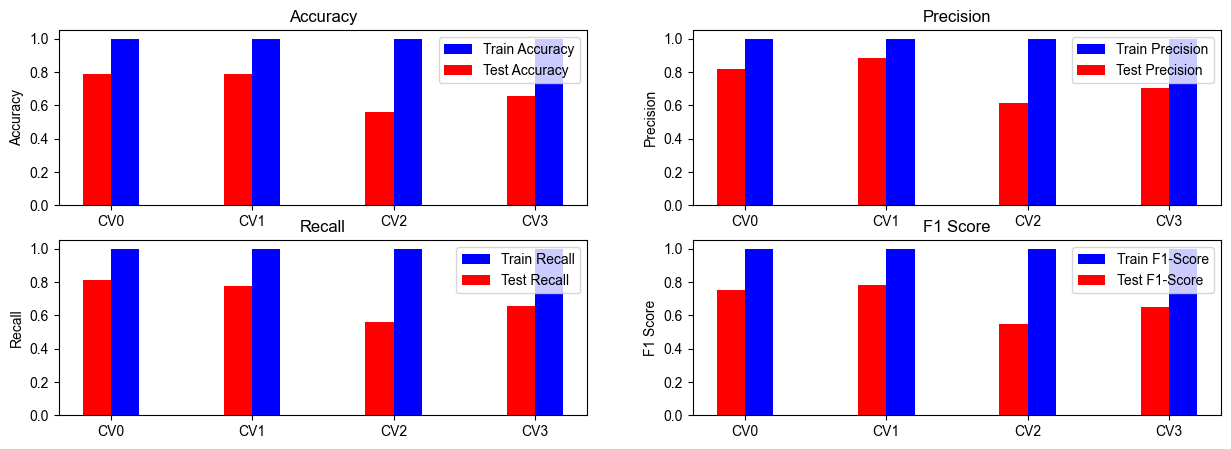

In [47]:
plot_eval_dict_barplot_new(eval_dict)

### c) Custom CV - with extracted features

In [48]:
# From now on we will use the following data
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,User,Class
0,31.220158,27.403799,-33.548944,5.0,-0.592168,-0.526425,0.610093,-0.679408,-0.080937,-0.729283,-0.433292,0.846361,0.309729,3303.459708,31.125729,393.299191,0,1
1,32.392560,27.823996,-32.104566,5.0,-0.612694,-0.533061,0.583483,-0.660054,-0.060910,-0.748745,-0.434667,0.843882,0.314529,3308.347956,26.851403,393.193165,0,1
2,32.081207,27.936918,-32.385520,5.0,-0.606186,-0.535279,0.588231,-0.658320,-0.077302,-0.748758,-0.446266,0.841131,0.305525,3313.095350,27.067267,395.055695,0,1
3,31.719552,27.575915,-32.964177,5.0,-0.600247,-0.529105,0.599793,-0.655695,-0.103896,-0.747843,-0.458004,0.842172,0.284569,3306.145497,27.729013,393.524673,0,1
4,31.594851,27.416170,-33.195235,5.0,-0.598431,-0.526505,0.603881,-0.657469,-0.108005,-0.745701,-0.457837,0.843284,0.281527,3304.675159,29.444009,393.498111,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,27.823671,97.288106,-29.054040,10.0,0.875153,-0.440633,-0.199875,-0.449442,-0.893308,0.001453,0.179191,-0.088561,0.979820,2029.730672,761.522468,584.641706,14,5
77220,28.021968,97.191781,-29.248339,10.0,0.869813,-0.446504,-0.209904,-0.461688,-0.886626,-0.027154,0.173982,-0.120529,0.977345,2064.006800,762.311322,588.108972,14,5
77221,28.103645,96.953570,-29.735080,10.0,0.865906,-0.452405,-0.213392,-0.472325,-0.879944,-0.051069,0.164669,-0.145012,0.975631,2074.594214,767.103862,592.169837,14,5
77222,20.384035,93.649845,-25.356364,9.0,0.213676,0.226960,0.950174,-0.815051,0.577614,0.045320,0.538548,0.784124,-0.308407,591.537322,1397.531289,1796.343364,14,5


In [49]:
# Hyperparameters:
#Random Forest raw features
rf_extract_hyperparams = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_leaf_nodes': max_leaf_nodes,
                'bootstrap': bootstrap,
                'oob_score': oob_score,
                'n_jobs': n_jobs,
                'random_state': random_state}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_aggregate, RandomForestClassifier, 'normalize', rf_extract_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 11, 6
Ratio of test set: 0.16106391795296798


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.9101141662646728
**************************************************
CV Run: 1
User picked for test set: 8, 10
Ratio of test set: 0.2121620221692738


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.808837890625
**************************************************
CV Run: 2
User picked for test set: 14, 1
Ratio of test set: 0.1581373666217756


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.6569767441860465
**************************************************
CV Run: 3
User picked for test set: 0, 2
Ratio of test set: 0.17560602921371593


/home/josh/miniconda3/envs/dde/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Train accuracy:  1.0
(CV-) Test accuracy:  0.7576874861735861


#### Evaluation

(12438, 5)
(12438,)
(12438,)
23383    1
23384    1
23385    1
23386    1
23387    1
        ..
56120    5
56121    5
56122    5
56123    5
56124    5
Name: Class, Length: 12438, dtype: int64
{'1': {'precision': 0.9825253664036077, 'recall': 0.7442356959863364, 'f1-score': 0.846938775510204, 'support': 2342}, '2': {'precision': 1.0, 'recall': 0.9602903501280956, 'f1-score': 0.979742975386626, 'support': 2342}, '3': {'precision': 0.7650273224043715, 'recall': 1.0, 'f1-score': 0.8668730650154799, 'support': 2380}, '4': {'precision': 0.9945848375451264, 'recall': 0.8396190476190476, 'f1-score': 0.9105556703160504, 'support': 2625}, '5': {'precision': 0.8886010362694301, 'recall': 0.9981811567842852, 'f1-score': 0.9402090114784992, 'support': 2749}, 'accuracy': 0.9101141662646728, 'macro avg': {'precision': 0.9261477125245072, 'recall': 0.908465250103553, 'f1-score': 0.9088638995413719, 'support': 12438}, 'weighted avg': {'precision': 0.9259839912124356, 'recall': 0.9101141662646728, 'f1-sc

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


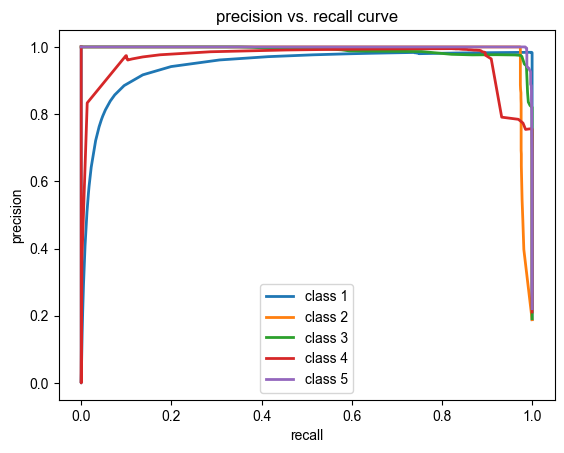

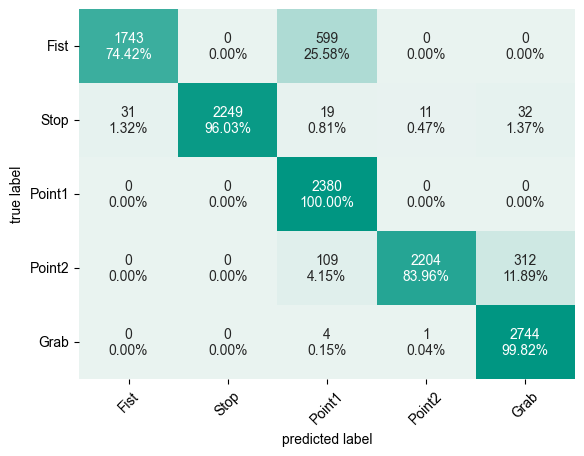

In [50]:
extract_w_cv_data_report = Report('rfc_extract', best_model, X_test_best, y_test_best, description=['cv_data', 'extracted features'])
df_results = extract_w_cv_data_report.get_report_as_df(df_results)
print(extract_w_cv_data_report)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred_cv_extract = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred_cv_extract)

With the extracted features the model improved in predicting "Point2" data points, but the perfomance for predicting "Grab" decreased

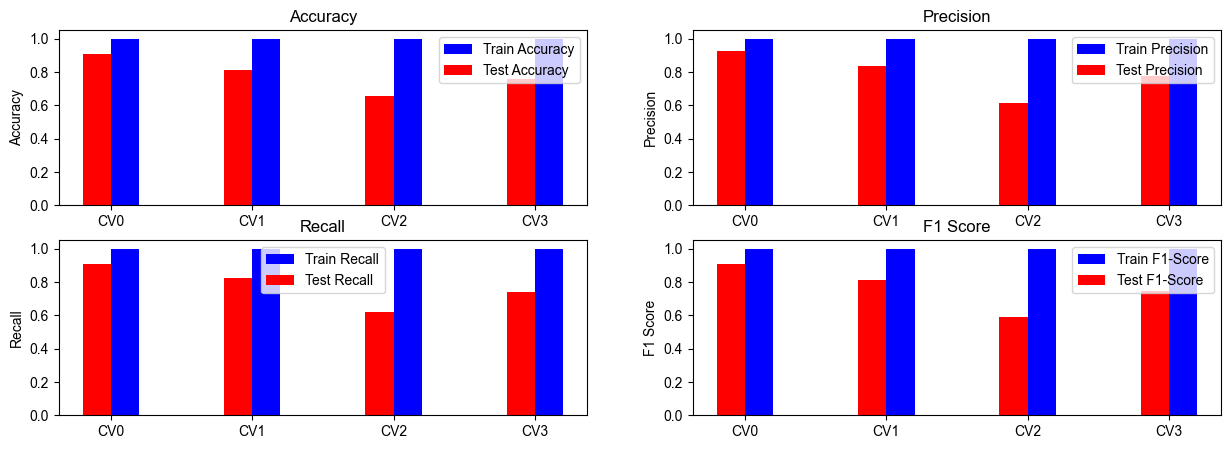

In [51]:
plot_eval_dict_barplot_new(eval_dict)

<Figure size 640x480 with 0 Axes>

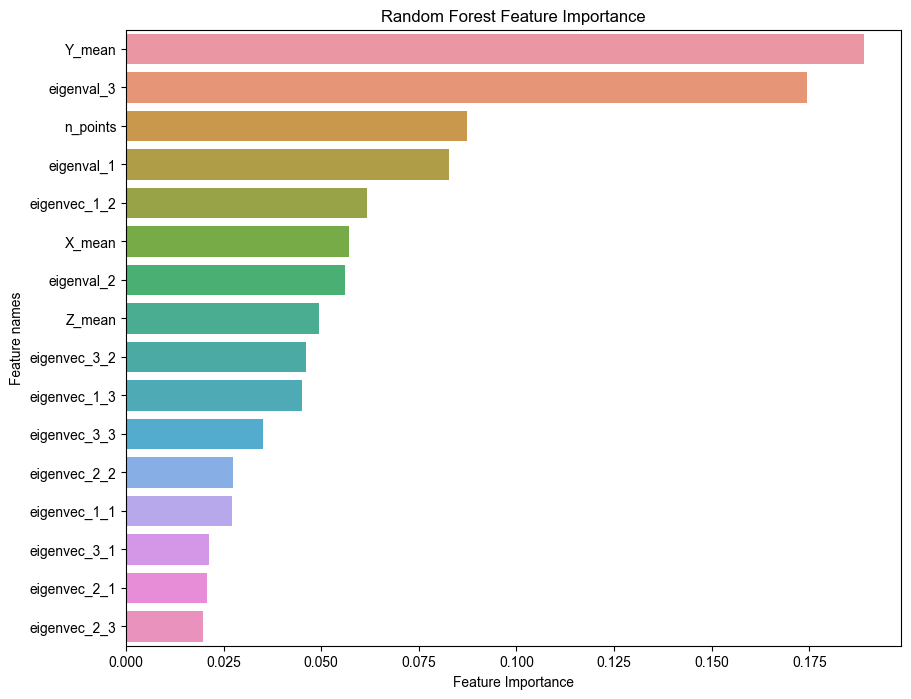

In [52]:
feature_list = df_aggregate.columns.to_list()
feature_list.remove('User')
feature_list.remove('Class')
plot_feature_importance_rf(best_model, feature_list)

## Logistic Regression

In [53]:
# Hyperparameters:
penalty = 'l2'
C = 1.0 #regularization strength. The smaller the value, the stronger the regularization.
random_state = 2023
solver = 'lbfgs' # One of the possible solver for multiclass problems (‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’)
max_iter = 300

### a) Custom CV - with raw data

In [54]:
# Hyperparameters:
#Logistic regression raw features
lg_raw_hyperparams = {'penalty': penalty,
                'C': C,
                'random_state': random_state,
                'solver': solver,
                'max_iter': max_iter}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_raw, LogisticRegression, 'standard', lg_raw_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 1, 11
Ratio of test set: 0.16546669429192998
Train accuracy:  0.8631412345219254
(CV-) Test accuracy:  0.77594302707779
**************************************************
CV Run: 1
User picked for test set: 8, 10
Ratio of test set: 0.2121620221692738
Train accuracy:  0.8541051142274562
(CV-) Test accuracy:  0.88385009765625
**************************************************
CV Run: 2
User picked for test set: 2, 9
Ratio of test set: 0.10920180254843054
Train accuracy:  0.8745363244088925
(CV-) Test accuracy:  0.7159966797106605
**************************************************
CV Run: 3
User picked for test set: 5, 6
Ratio of test set: 0.12278566248834559
Train accuracy:  0.9190964275052244
(CV-) Test accuracy:  0.5602193630035858


Error occured:
ConvergenceWarning: lbfgs failed to converge (status=1)
-> increase max_iter

#### Evaluation

(16384, 5)
(16384,)
(16384,)
27760    1
27761    1
27762    1
27763    1
27764    1
        ..
48059    5
48060    5
48061    5
48062    5
48063    5
Name: Class, Length: 16384, dtype: int64
{'1': {'precision': 0.8569317901994583, 'recall': 0.9959931310818546, 'f1-score': 0.9212442091330245, 'support': 3494}, '2': {'precision': 0.9638723254998246, 'recall': 0.9564914723285765, 'f1-score': 0.960167714884696, 'support': 2873}, '3': {'precision': 0.8624084827063873, 'recall': 0.9041821069348862, 'f1-score': 0.882801395529138, 'support': 3778}, '4': {'precision': 0.8413926499032882, 'recall': 0.8546168958742633, 'f1-score': 0.847953216374269, 'support': 3054}, '5': {'precision': 0.9244499792444998, 'recall': 0.6992150706436421, 'f1-score': 0.7962102252413299, 'support': 3185}, 'accuracy': 0.88385009765625, 'macro avg': {'precision': 0.8898110455106917, 'recall': 0.8820997353726445, 'f1-score': 0.8816753522324916, 'support': 16384}, 'weighted avg': {'precision': 0.8871759308154912, 'recall'

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


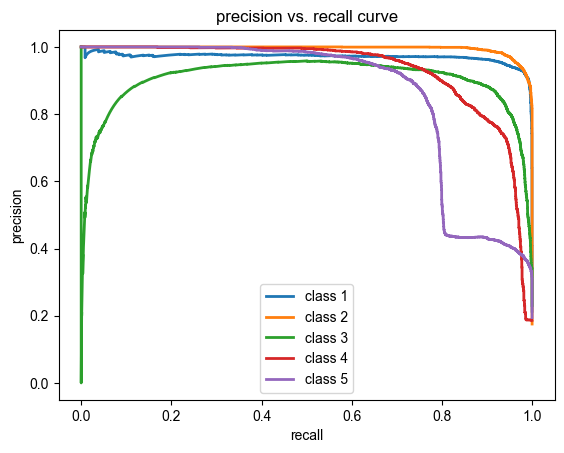

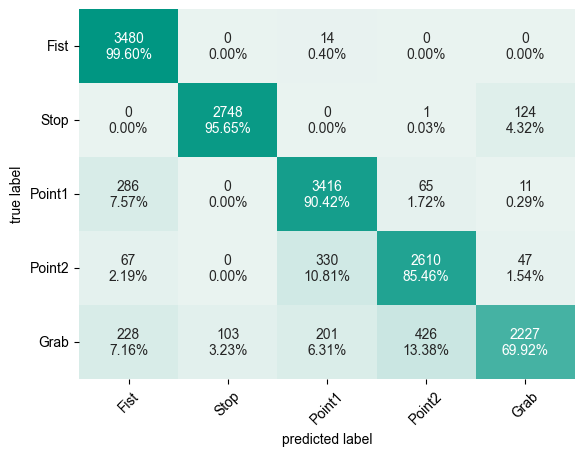

In [55]:
raw_w_cv_data_report_lg = Report('lg_raw', best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'raw features'])
df_results = raw_w_cv_data_report_lg.get_report_as_df(df_results)
print(raw_w_cv_data_report_lg)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

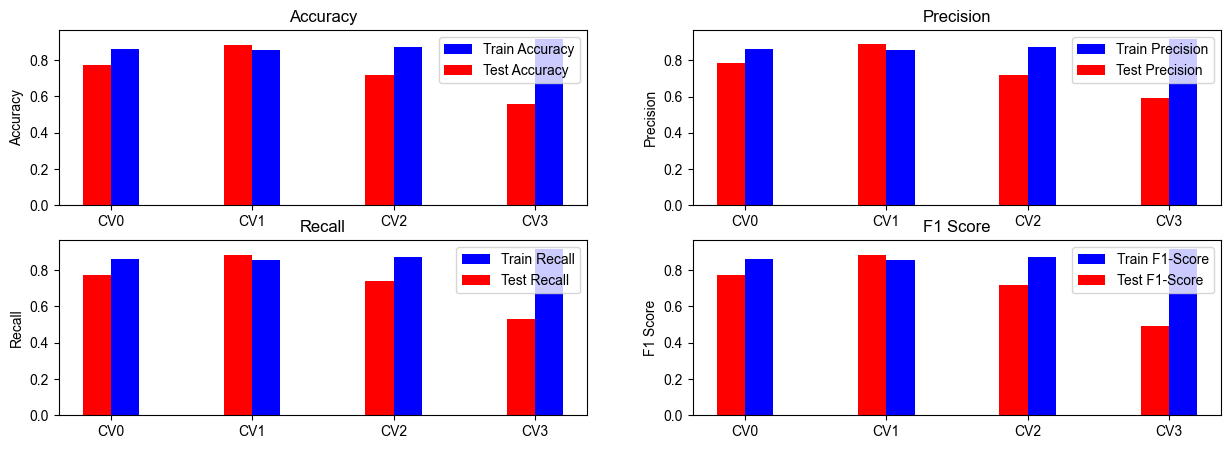

In [56]:
plot_eval_dict_barplot_new(eval_dict)

### b) Custom CV - with extracted features

In [57]:
# Hyperparameters:
#Logistic regression extract features
lg_extract_hyperparams = {'penalty': penalty,
                'C': C,
                'random_state': random_state,
                'solver': solver,
                'max_iter': max_iter}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_aggregate, LogisticRegression, 'standard', lg_extract_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 0, 6
Ratio of test set: 0.17384491867813115
Train accuracy:  0.9109390429317074
(CV-) Test accuracy:  0.8559404096834264
**************************************************
CV Run: 1
User picked for test set: 13, 11
Ratio of test set: 0.21754894851341552
Train accuracy:  0.9161897061639609
(CV-) Test accuracy:  0.7477976190476191
**************************************************
CV Run: 2
User picked for test set: 12, 10
Ratio of test set: 0.18696260229980316
Train accuracy:  0.9528884248026781
(CV-) Test accuracy:  0.6385926028535809
**************************************************
CV Run: 3
User picked for test set: 8, 9
Ratio of test set: 0.13895939086294415
Train accuracy:  0.963307375171782
(CV-) Test accuracy:  0.5431926195135588


#### Evaluation

(13425, 5)
(13425,)
(13425,)
0        1
1        1
2        1
3        1
4        1
        ..
27755    5
27756    5
27757    5
27758    5
27759    5
Name: Class, Length: 13425, dtype: int64
{'1': {'precision': 0.9963884430176565, 'recall': 0.9513409961685824, 'f1-score': 0.973343786750294, 'support': 2610}, '2': {'precision': 0.8637587506731287, 'recall': 0.6512383272431993, 'f1-score': 0.7425925925925926, 'support': 2463}, '3': {'precision': 0.9349397590361446, 'recall': 0.8851711026615969, 'f1-score': 0.9093749999999999, 'support': 2630}, '4': {'precision': 0.8383301707779887, 'recall': 0.8748514851485149, 'f1-score': 0.8562015503875969, 'support': 2525}, '5': {'precision': 0.7256390787142496, 'recall': 0.8967782295902409, 'f1-score': 0.802182428651371, 'support': 3197}, 'accuracy': 0.8559404096834264, 'macro avg': {'precision': 0.8718112404438336, 'recall': 0.8518760281624267, 'f1-score': 0.8567390716763708, 'support': 13425}, 'weighted avg': {'precision': 0.8658141542877421, 'reca

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


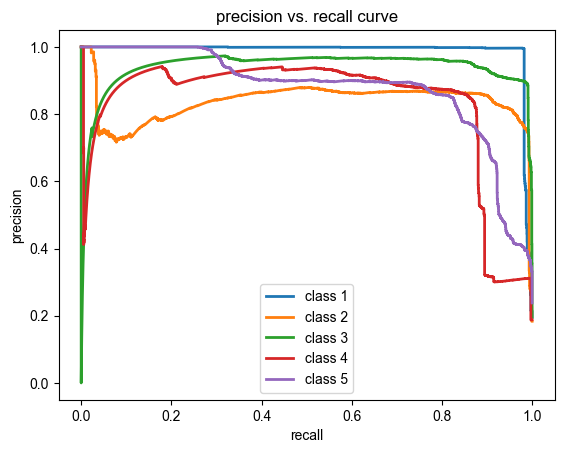

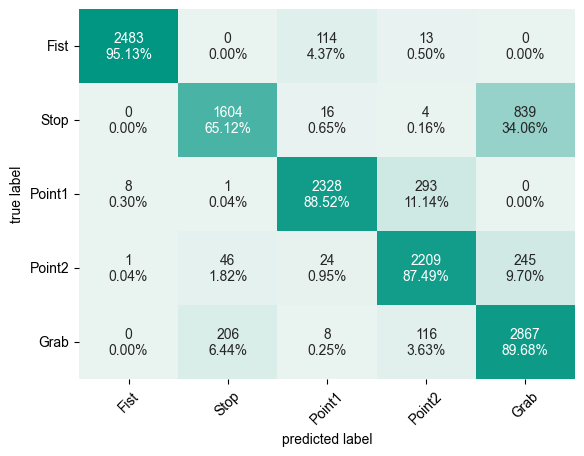

In [58]:
extract_w_cv_data_report_lg = Report('lg_extract', best_model, X_test_best, y_test_best, description=['LogReg', 'cv_data', 'extracted features'])
df_results = extract_w_cv_data_report_lg.get_report_as_df(df_results)
print(extract_w_cv_data_report_lg)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

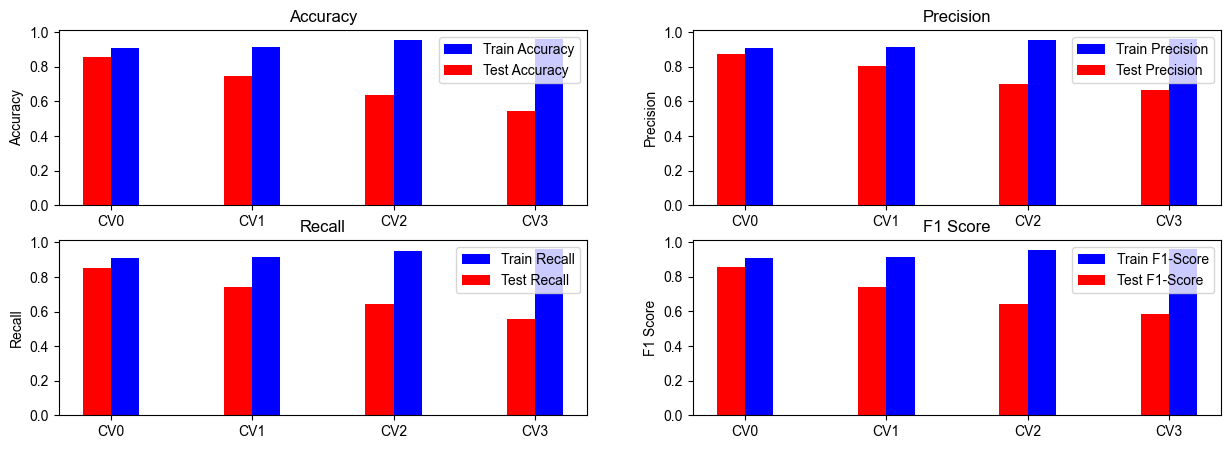

In [59]:
plot_eval_dict_barplot_new(eval_dict)

## Support Vector Machine (SVM)

### a) Custom CV - with raw data

In [60]:
# Hyperparameters:
#SVC_raw
svc_raw_hyperparams = {
    'C': 1.0, #regularization strength. The smaller the value, the stronger the regularization.
    'gamma':'scale',
    'kernel': 'rbf',
    'decision_function_shape': 'ovo',
    'random_state': 2023,
    'max_iter': -1, # -1 means no limit
    'cache_size': 200, # in MB
    'probability': True # needed for predict_proba later on
}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_raw, SVC, 'standard', svc_raw_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 12, 10
Ratio of test set: 0.18696260229980316
Train accuracy:  0.9937884241709936
(CV-) Test accuracy:  0.8779609364177864
**************************************************
CV Run: 1
User picked for test set: 8, 1
Ratio of test set: 0.149280016575158
Train accuracy:  0.9941082367630418
(CV-) Test accuracy:  0.7486120749479528
**************************************************
CV Run: 2
User picked for test set: 5, 11
Ratio of test set: 0.17049103905521598
Train accuracy:  0.9944870313976688
(CV-) Test accuracy:  0.7137323408780192
**************************************************
CV Run: 3
User picked for test set: 2, 13
Ratio of test set: 0.1716046824821299
Train accuracy:  0.9942028985507246
(CV-) Test accuracy:  0.6906881980078479


#### Evaluation

(14438, 5)
(14438,)
(14438,)
38491    1
38492    1
38493    1
38494    1
38495    1
        ..
60985    5
60986    5
60987    5
60988    5
60989    5
Name: Class, Length: 14438, dtype: int64
{'1': {'precision': 0.8959654178674351, 'recall': 1.0, 'f1-score': 0.9451284389724881, 'support': 3109}, '2': {'precision': 0.9930270713699754, 'recall': 0.999587118084228, 'f1-score': 0.9962962962962962, 'support': 2422}, '3': {'precision': 0.7858805275407292, 'recall': 0.6341158059467918, 'f1-score': 0.7018880997748138, 'support': 3195}, '4': {'precision': 0.8055034396497811, 'recall': 0.8293625241468127, 'f1-score': 0.8172588832487311, 'support': 3106}, '5': {'precision': 0.9237472766884531, 'recall': 0.9762087490406753, 'f1-score': 0.9492537313432836, 'support': 2606}, 'accuracy': 0.8779609364177864, 'macro avg': {'precision': 0.8808247466232748, 'recall': 0.8878548394437015, 'f1-score': 0.8819650899271225, 'support': 14438}, 'weighted avg': {'precision': 0.873440602791446, 'recall': 0.87796093

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


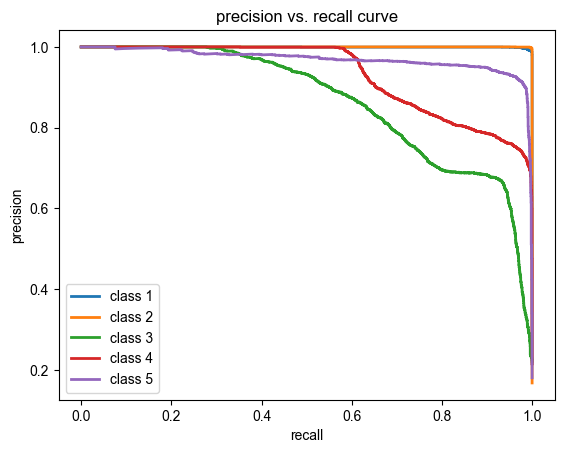

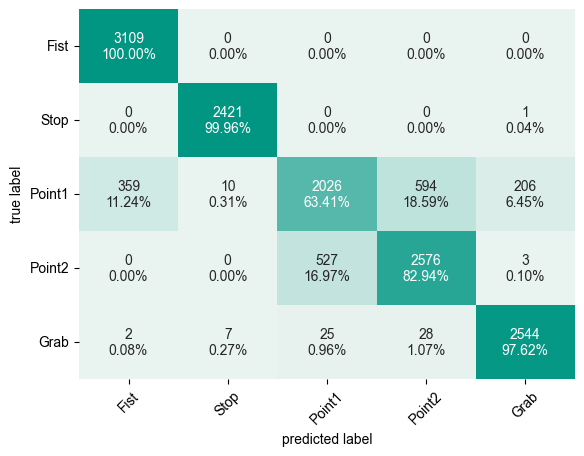

In [61]:
raw_w_cv_data_report_svm = Report('svm_raw', best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'raw features'])
df_results = raw_w_cv_data_report_svm.get_report_as_df(df_results)
print(raw_w_cv_data_report_svm)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

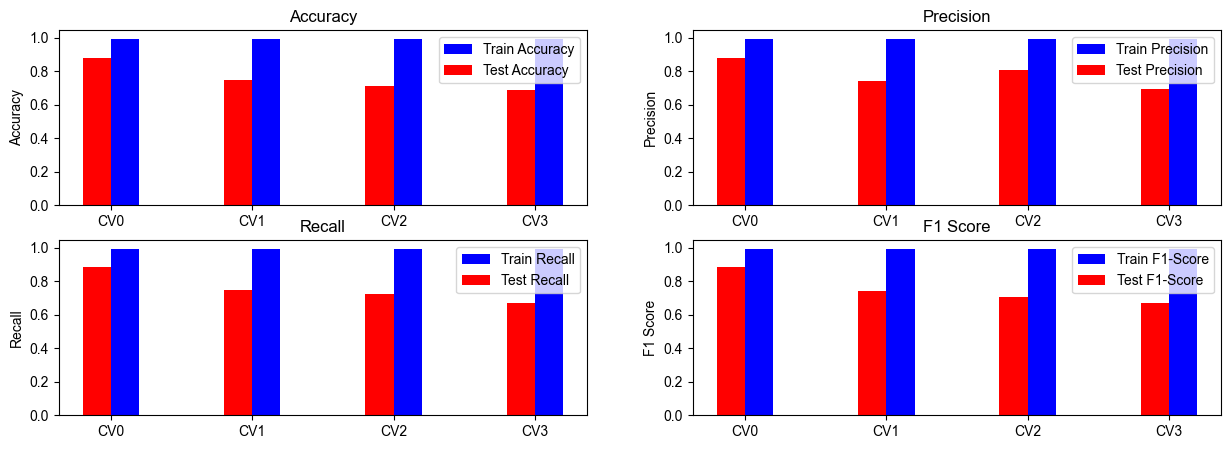

In [62]:
plot_eval_dict_barplot_new(eval_dict)

### b) Custom CV - with extracted features

In [63]:
# Hyperparameters:
#SVC_aggregate
svc_extract_hyperparams = {
    'C': 1.0, #regularization strength. The smaller the value, the stronger the regularization.
    'gamma':'scale',
    'kernel': 'rbf',
    'decision_function_shape': 'ovo',
    'random_state': 2023,
    'max_iter': -1, # -1 means no limit
    'cache_size': 200, # in MB
    'probability': True # needed for predict_proba later on
}

best_model, X_test_best, y_test_best, eval_dict = train_model(df_aggregate, SVC, 'standard', svc_extract_hyperparams)

**************************************************
CV Run: 0
User picked for test set: 13, 14
Ratio of test set: 0.21021962084326115
Train accuracy:  0.9977865223807182
(CV-) Test accuracy:  0.8204385856843661
**************************************************
CV Run: 1
User picked for test set: 10, 2
Ratio of test set: 0.18240443385476018
Train accuracy:  0.9975695036670646
(CV-) Test accuracy:  0.8171233849211984
**************************************************
CV Run: 2
User picked for test set: 5, 9
Ratio of test set: 0.11686781311509375
Train accuracy:  0.9971488159666306
(CV-) Test accuracy:  0.7165650969529086
**************************************************
CV Run: 3
User picked for test set: 12, 11
Ratio of test set: 0.16738319693359577
Train accuracy:  0.9985172123592354
(CV-) Test accuracy:  0.8247717778121615


#### Evaluation

(12926, 5)
(12926,)
(12926,)
48064    1
48065    1
48066    1
48067    1
48068    1
        ..
60985    5
60986    5
60987    5
60988    5
60989    5
Name: Class, Length: 12926, dtype: int64
{'1': {'precision': 0.9079983423124741, 'recall': 0.946027633851468, 'f1-score': 0.9266229646859802, 'support': 2316}, '2': {'precision': 1.0, 'recall': 0.5161568289530375, 'f1-score': 0.6808752486501848, 'support': 2321}, '3': {'precision': 0.9238356164383562, 'recall': 0.6272321428571429, 'f1-score': 0.7471748282738756, 'support': 2688}, '4': {'precision': 0.9926068788171006, 'recall': 0.9983834464920789, 'f1-score': 0.9954867827208252, 'support': 3093}, '5': {'precision': 0.5704498744005481, 'recall': 0.9960127591706539, 'f1-score': 0.7254247132278205, 'support': 2508}, 'accuracy': 0.8247717778121615, 'macro avg': {'precision': 0.8789781423936958, 'recall': 0.8167625622648762, 'f1-score': 0.8151169075117372, 'support': 12926}, 'weighted avg': {'precision': 0.8825634890112841, 'recall': 0.8247717

/tmp/ipykernel_271806/1335205042.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_to_save_to = df_to_save_to.append(new_row, ignore_index=True)


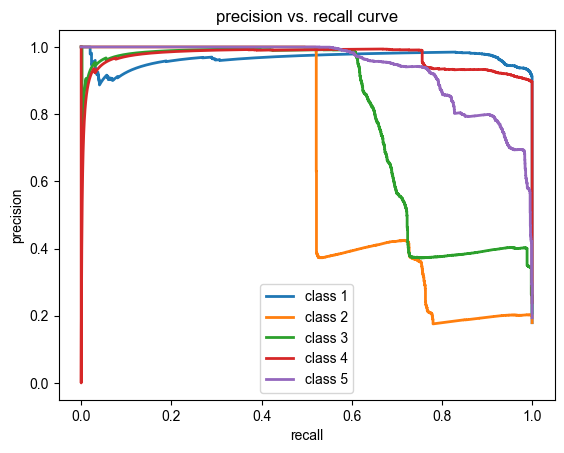

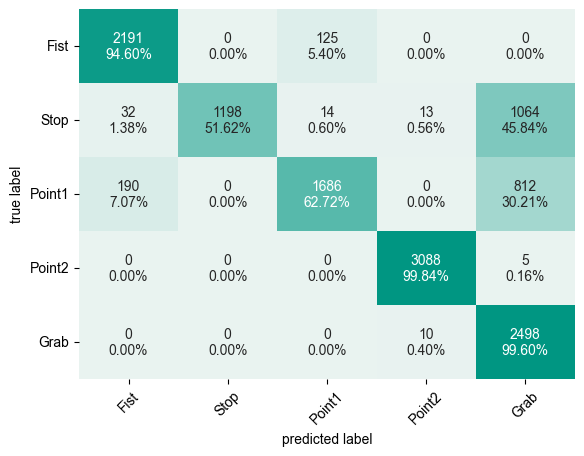

In [64]:
extract_w_cv_data_report_svm = Report('svm_extract', best_model, X_test_best, y_test_best, description=['SVM', 'cv_data', 'extracted features'])
df_results = extract_w_cv_data_report_svm.get_report_as_df(df_results)
print(extract_w_cv_data_report_svm)
precision_recall_multiclass(best_model, X_test_best, y_test_best)
y_pred = best_model.predict(X_test_best)
plot_cm(y_test_best, y_pred)

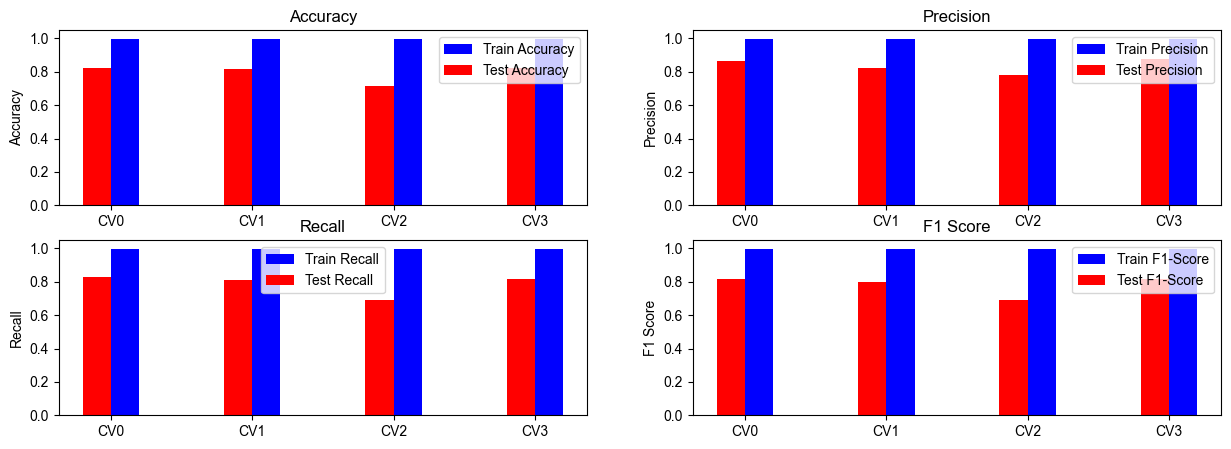

In [65]:
plot_eval_dict_barplot_new(eval_dict)

TODO other models to try <br>
LightGBM

In [66]:
#TODO boxplot of the results
'''
ax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sns.set(rc = {'figure.figsize':(8,10)})
ax.set(ylabel='F2-Score')
ax.set_title('F2-Score Deviation of different Models')
'''

"\nax = sns.boxplot(data = f2_df, linewidth=1, showfliers=False)\nax.set_xticklabels(ax.get_xticklabels(),rotation=90)\nsns.set(rc = {'figure.figsize':(8,10)})\nax.set(ylabel='F2-Score')\nax.set_title('F2-Score Deviation of different Models')\n"

## Conclusion Testing Phase I

In [67]:
def plot_model_comparison(df_results):
    '''
    Plot a comparison of the models based on the evaluation metrics
    '''

    df = df_results.copy()
    # Set the model as the index
    df.set_index('model', inplace=True)
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))
    # Create color list
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


    # Plot each metric in a subplot
    for i, metric in enumerate(df.columns):
        row = i // 2
        col = i % 2
        axs[row, col].bar(df.index, df[metric], color=colors[:len(df.index)], width=0.3)
        axs[row, col].set_xlabel('Model')
        axs[row, col].set_ylabel(metric)
        axs[row, col].set_title(f'{metric} Comparison')
        axs[row, col].set_ylim([0, 1])

    # Adjust the spacing between subplots
    plt.tight_layout()
    # Display the plots
    plt.show()


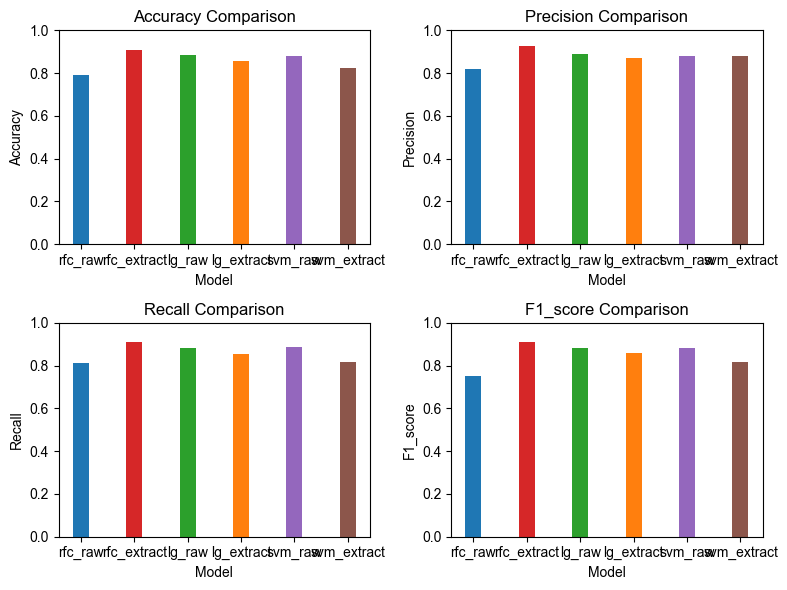

In [68]:
plot_model_comparison(df_results)

TODO

Extracted features?
* good, we see an improvement ...

Confusion Matrix:
* what cases are difficult
* which are easy
* explanation why

Feature reduction
* good/bad
* PCA
* which models got worses

Best model:
* e.g. rf with extracted data

# 4. Testing Phase II: Model Develepoment

## Base MLP structure

* Activation Functions
    - output layer: one neuron for each class (5)
    - we want the the probability of the each class, -> **softmax**
    - hidden Layer: start with **ReLU**

* Optimizer
    - **rmsprop**

* loss
    - **categorical_crossentropy**

* Hidden Layers and Number of Neurons
    - start with small architecture, increase size

* Metric
    - **accuracy**
    - **precission**


In [69]:
from tensorflow import keras
from tensorflow.keras import layers


def build_mlp_model(name:str, hyperparams:dict, input_shape: tuple, output_shape: int) -> keras.Sequential:
    'Build MLP classification network'

    model = keras.Sequential(name=name)
    model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_shape, activation='softmax'))

    model.compile(optimizer=hyperparams['optimizer'], loss=hyperparams['loss'], metrics=hyperparams['metrics'])

    return model

In [70]:
def plot_learning_curves(hist, parameters, name:str):
    
    plt.plot(hist['epoch'][:],hist['loss'][:], "k--", linewidth=1.5, label="Training")
    plt.plot(hist['epoch'][:],hist['val_loss'][:], "b-.", linewidth=1.5, label="CV test")
    plt.legend()
    plt.ylim(0,max(hist['loss'][:].max(), hist['val_loss'][:].max())+0.2)
    plt.xlabel("Epochs"),  plt.ylabel("categorical_crossentropy")

    plt.title(f'Learning Curve: {name}', fontsize=18)
    plt.show()

In [71]:
def plot_multiple_learning_curves(name, hyperparams):
    """
    Plot the learning curves for each cv run
    """

    # Load hist of every cv run

    all_hist = []

    for i in range(4):
        hist = load_history(f'{name}_cv{i}')
        all_hist.append(hist)
        
    # Plot the learning curves for each cv run
    for i in range(4):
        plot_learning_curves(all_hist[i], hyperparams, f'{name}_cv{i}')


In [72]:
def save_history(hist, name):

    # Get path to save the history
    hist_folder = 'model/single_run/history'
    model_path = join(hist_folder, name)
    
    with open(model_path, 'wb') as file_pi:
        pickle.dump(hist, file_pi)

def load_history(name):

    # Get path to save the history
    hist_folder = 'model/single_run/history'
    model_path = join(hist_folder, name)
    
    with open(model_path, 'rb') as file_pi:
        history = pickle.load(file_pi)
    
    return history

In [73]:
def load_model(name):

    # Get path to save the history
    model_folder = 'model/single_run'
    model_path = join(model_folder, name)
    
    model = keras.models.load_model(model_path)
    
    return model

In [74]:
def list_used_parameters(parameters:dict):
    print('Used parameters:')
    for parameter, value in parameters.items():
        print(f'{parameter}: {value}')

In [75]:
def decode_one_hot(one_hot_encoded):
    return np.argmax(one_hot_encoded)

In [76]:
def calc_f1_score_mlp(model, X, y):
    # Calculate f1 score of mlp
    y_pred1 = model.predict(X)
    y_pred = np.argmax(y_pred1, axis=1)

    # to one hot encoding
    y_pred = to_categorical(y_pred)

    return f1_score(y, y_pred , average="macro")

In [77]:
def train_k_mlp_model(name, df:pd.DataFrame, hyperparams:dict):
    '''
    Train a MLP model with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, The best test set.
    y_test_best : numpy.ndarray, The best test set.
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    # Evaluation dict
    eval_dict = {'train': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []},
                 'test': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []}}

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data #TODO rename to X_train etc. because function also use by raw and later pca
        X_train_cv_extract, y_train_cv_extract, X_test_cv_extract, y_test_cv_extract, user_list = custom_cv_approach(df, user_list, num_user_test=num_user_test)

        # Normalize the data
        scaler = MinMaxScaler()
        scaler.fit(X_train_cv_extract)
        X_train_cv_extract = scaler.transform(X_train_cv_extract)
        X_test_cv_extract = scaler.transform(X_test_cv_extract)
        # Befor one hot encoding, class has to start at 0
        y_train_cv_extract = y_train_cv_extract-1
        y_test_cv_extract = y_test_cv_extract-1
        # y label to one hot encode
        y_train_cv_extract = to_categorical(y_train_cv_extract)
        y_test_cv_extract = to_categorical(y_test_cv_extract)

        # Build the model
        # TODO
        mlp_model = build_mlp_model(name, hyperparams, input_shape=X_train_cv_extract.shape[1:], output_shape=y_train_cv_extract.shape[1])

        # Only print the model summary once
        if describe_model:
            mlp_model.summary()
            describe_model = False

        # Create callback
        # Use early stopping later because it is a form of regularization
        #early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)

        # Train the model
        history = mlp_model.fit(X_train_cv_extract, 
                                y_train_cv_extract, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_extract, y_test_cv_extract),
                                verbose=1,
                                shuffle=True,
                                callbacks=[checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Save the history
        save_history(hist, f'{name}_cv{i}')

        #Evaluating the training performance:
        train_loss, train_acc, train_precision, train_recall = mlp_model.evaluate(x=X_train_cv_extract, y=y_train_cv_extract, batch_size=hyperparams['batch_size'], verbose=3)
        f1_score_train = calc_f1_score_mlp(mlp_model, X_train_cv_extract, y_train_cv_extract)

        eval_dict = save_to_eval_dict(eval_dict, 'train', train_acc, train_precision, train_recall, f1_score_train)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision, val_recall = mlp_model.evaluate(x=X_test_cv_extract, y=y_test_cv_extract, batch_size=hyperparams['batch_size'], verbose=0)
        f1_score_test = calc_f1_score_mlp(mlp_model, X_test_cv_extract, y_test_cv_extract)
        eval_dict = save_to_eval_dict(eval_dict, 'test', val_acc, val_precision, val_recall, f1_score_test)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if val_acc > best_acc:
            best_model = mlp_model
            best_acc = val_acc
            X_test_best = X_test_cv_extract
            y_test_best = y_test_cv_extract

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Save the evaluation dict
    save_eval_dict_pkl(eval_dict, f'{name}_eval_dict')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best, eval_dict


In [78]:
# Hyperparameters
#TODO set number of epochs to 15
#TODO 45 per k fold (4 folds) will take 5 hours #40 is fine # 35 is fine
#TODO use hidden layer and units hl
hyperparams = {'num_epochs': 35,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metrics': ['categorical_accuracy', 'Precision', tf.keras.metrics.Recall()],
               'optimizer': keras.optimizers.legacy.Adam(),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

2023-03-10 18:21:36.535058: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/Documents/seam_eng/group4_ws/devel/lib:/opt/ros/noetic/lib
2023-03-10 18:21:36.535096: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 18:21:36.535119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (josh): /proc/driver/nvidia/version does not exist
2023-03-10 18:21:36.535377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compile

### a) Custom CV - with raw data

To get an Idea How long the model trains: <br>
13 min 30 sec for 4 runs
* each trains for 2 epochs

Highly depends on the used Hardware! <br>
Here we use an M1 macbook with GPU tf vesion

**************************************************
CV Run: 0
User picked for test set: 6, 10
Ratio of test set: 0.18064332331917538
Model: "mlp_base_model_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                992       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 5)          

6328/6328 [==============================] - 11s 2ms/step - loss: 0.0775 - categorical_accuracy: 0.9740 - precision: 0.9751 - recall: 0.9733 - val_loss: 0.4695 - val_categorical_accuracy: 0.8335 - val_precision: 0.8350 - val_recall: 0.8316
Epoch 29/35
6328/6328 [==============================] - 11s 2ms/step - loss: 0.0750 - categorical_accuracy: 0.9751 - precision: 0.9760 - recall: 0.9743 - val_loss: 0.5956 - val_categorical_accuracy: 0.7991 - val_precision: 0.8066 - val_recall: 0.7935
Epoch 30/35
6328/6328 [==============================] - 11s 2ms/step - loss: 0.0737 - categorical_accuracy: 0.9755 - precision: 0.9763 - recall: 0.9749 - val_loss: 0.5555 - val_categorical_accuracy: 0.8220 - val_precision: 0.8227 - val_recall: 0.8199
Epoch 31/35
6328/6328 [==============================] - 11s 2ms/step - loss: 0.0741 - categorical_accuracy: 0.9753 - precision: 0.9761 - recall: 0.9746 - val_loss: 0.6532 - val_categorical_accuracy: 0.7891 - val_precision: 0.7931 - val_recall: 0.7848
Epoc

Epoch 24/35
5035/5035 [==============================] - 9s 2ms/step - loss: 0.0873 - categorical_accuracy: 0.9688 - precision: 0.9693 - recall: 0.9684 - val_loss: 2.0702 - val_categorical_accuracy: 0.6160 - val_precision: 0.6189 - val_recall: 0.6110
Epoch 25/35
5035/5035 [==============================] - 9s 2ms/step - loss: 0.0828 - categorical_accuracy: 0.9710 - precision: 0.9714 - recall: 0.9706 - val_loss: 2.2760 - val_categorical_accuracy: 0.5839 - val_precision: 0.5853 - val_recall: 0.5818
Epoch 26/35
5035/5035 [==============================] - 9s 2ms/step - loss: 0.0807 - categorical_accuracy: 0.9718 - precision: 0.9725 - recall: 0.9714 - val_loss: 1.5679 - val_categorical_accuracy: 0.6884 - val_precision: 0.6923 - val_recall: 0.6840
Epoch 27/35
5035/5035 [==============================] - 9s 2ms/step - loss: 0.0795 - categorical_accuracy: 0.9715 - precision: 0.9722 - recall: 0.9710 - val_loss: 2.4242 - val_categorical_accuracy: 0.6064 - val_precision: 0.6102 - val_recall: 0.6

Epoch 20/35
3412/3412 [==============================] - 7s 2ms/step - loss: 0.1074 - categorical_accuracy: 0.9586 - precision: 0.9592 - recall: 0.9582 - val_loss: 1.9596 - val_categorical_accuracy: 0.5204 - val_precision: 0.5221 - val_recall: 0.5171
Epoch 21/35
3412/3412 [==============================] - 7s 2ms/step - loss: 0.1071 - categorical_accuracy: 0.9595 - precision: 0.9600 - recall: 0.9588 - val_loss: 1.7250 - val_categorical_accuracy: 0.6291 - val_precision: 0.6328 - val_recall: 0.6254
Epoch 22/35
3412/3412 [==============================] - 7s 2ms/step - loss: 0.1003 - categorical_accuracy: 0.9619 - precision: 0.9625 - recall: 0.9614 - val_loss: 2.8621 - val_categorical_accuracy: 0.5596 - val_precision: 0.5623 - val_recall: 0.5554
Epoch 23/35
3412/3412 [==============================] - 7s 2ms/step - loss: 0.0972 - categorical_accuracy: 0.9622 - precision: 0.9629 - recall: 0.9616 - val_loss: 2.1252 - val_categorical_accuracy: 0.5795 - val_precision: 0.5818 - val_recall: 0.5

Epoch 15/35
1826/1826 [==============================] - 4s 2ms/step - loss: 1.6032 - categorical_accuracy: 0.2311 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6140 - val_categorical_accuracy: 0.2229 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/35
1826/1826 [==============================] - 4s 2ms/step - loss: 1.6032 - categorical_accuracy: 0.2311 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6129 - val_categorical_accuracy: 0.2229 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/35
1826/1826 [==============================] - 4s 2ms/step - loss: 1.6031 - categorical_accuracy: 0.2296 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6135 - val_categorical_accuracy: 0.2229 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/35
1826/1826 [==============================] - 4s 2ms/step - loss: 1.6032 - categorical_accuracy: 0.2311 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.6130 - val_categorical_ac

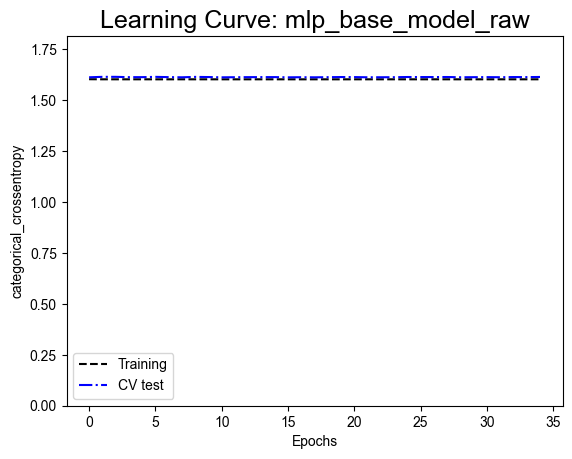

In [79]:
name = 'mlp_base_model_raw'
df = df_raw
best_model, best_acc, X_test_best, y_test_best, eval_dict = train_k_mlp_model(name, df, hyperparams)

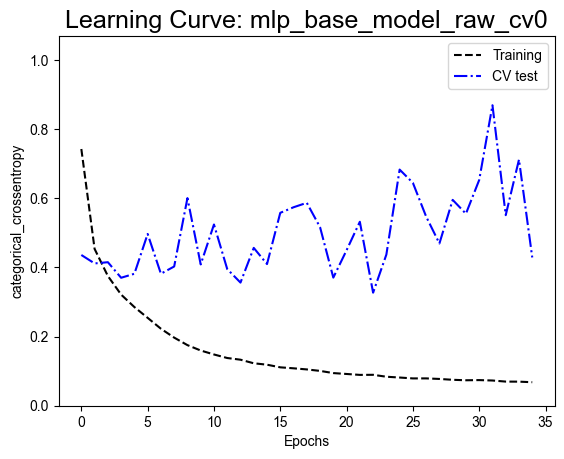

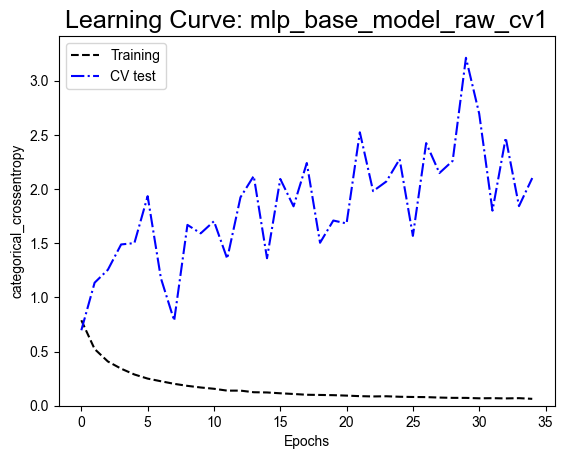

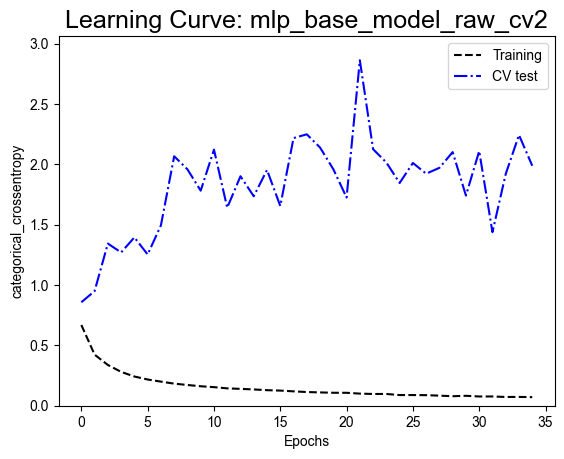

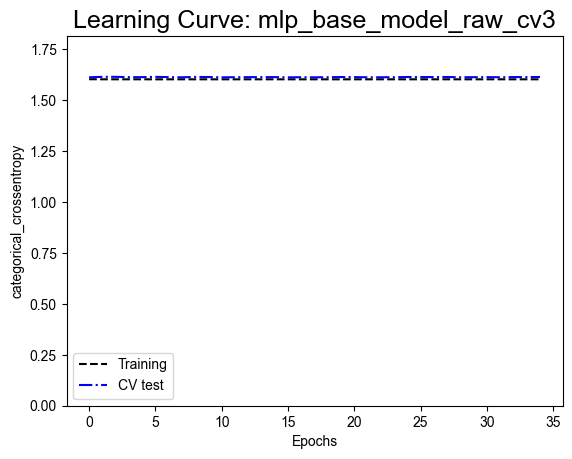

In [80]:
plot_multiple_learning_curves(name, {'test': 'test'})

436/436 [==============================] - 0s 855us/step
(13950, 5)
(13950, 5)
(13950, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
(13950, 5)
(13950, 5)

        ***********************REPORT*******************************
        Average (macro) precision: 0.89031
        Average accuracy: 0.872903
        Average (macro) recall: 0.863816
        Average (macro) f1-score: 0.868899
        Description MLP base, cv_data, raw features
        ************************************************************
        
436/436 [==============================] - 0s 784us/step


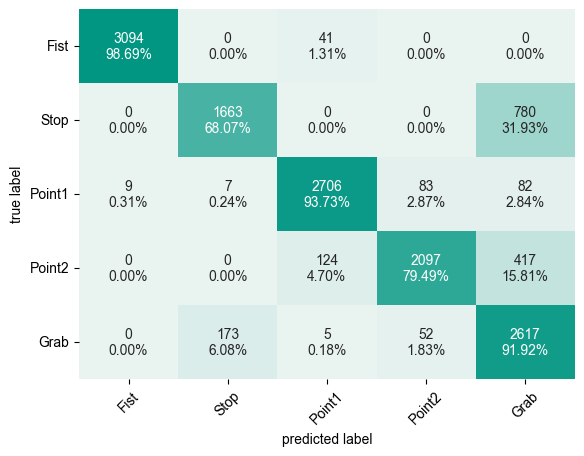

In [81]:
#adjust to mlp, KeyError: 'accuracy'
data_report_mlp_base_raw = Report('mlp_raw', best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'raw features'])
#df_results = data_report_mlp_base_raw.get_report_as_df(df_results)
print(data_report_mlp_base_raw)

# Prepare data to be compatible with confusion matrix function
y_pred = best_model.predict(X_test_best)
y_pred = np.argmax(y_pred, axis=1)+1
y_test_best = np.argmax(y_test_best, axis=1)+1
plot_cm(y_test_best, y_pred)

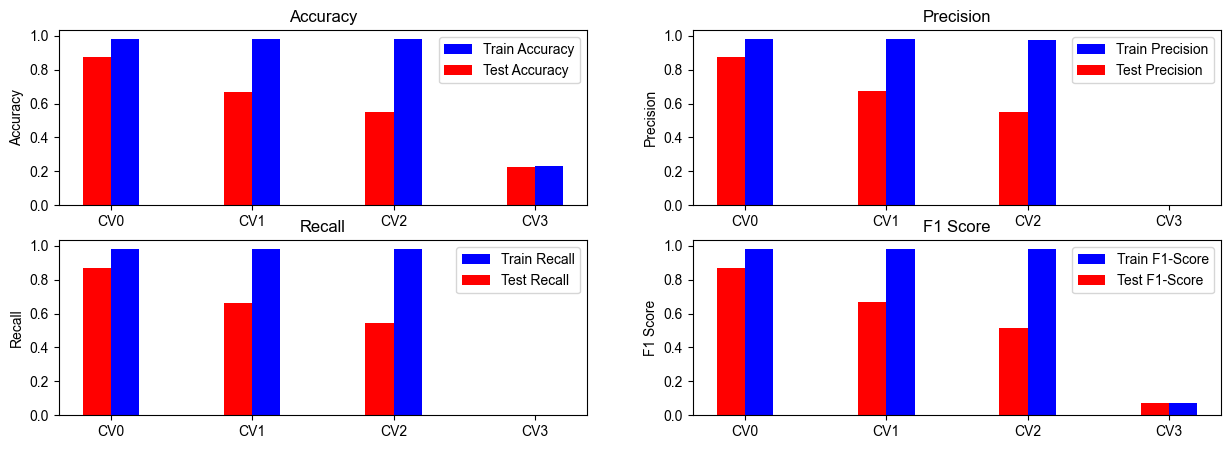

In [82]:
plot_eval_dict_barplot_new(eval_dict)

In [83]:
run_mode = 'retrain' # 'retrain' or 'load_model'
if run_mode == 'load_model':
    hist = load_history('mlp_base_model_raw_cv3')
    plot_learning_curves(hist, hyperparams, 'test')
    eval_dict = load_eval_dict_pkl('mlp_base_model_raw_eval_dict')
    plot_eval_dict_barplot_new(eval_dict)

First I tried a model with 32 16 8 units in the hidden layer<br>
the validation los increased rigth from the beginning while the test loss was decreasing, which is a sign of overfitting<br>
insert pic 

### b) Custom CV - with extracted features

#### Training

In [84]:
name = 'mlp_base_model_extracted'
df = df_aggregate
best_model, best_acc, X_test_best, y_test_best, eval_dict = train_k_mlp_model(name, df, hyperparams)

**************************************************
CV Run: 0
User picked for test set: 0, 6
Ratio of test set: 0.17384491867813115
Model: "mlp_base_model_extracted"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 16)                528       
                                                                 
 dense_28 (Dense)            (None, 8)                 136       
                                                                 
 dense_29 (Dense)            (None, 5)     

6380/6380 [==============================] - 11s 2ms/step - loss: 0.0107 - categorical_accuracy: 0.9966 - precision: 0.9967 - recall: 0.9965 - val_loss: 1.6157 - val_categorical_accuracy: 0.7440 - val_precision: 0.7455 - val_recall: 0.7420
Epoch 29/35
6380/6380 [==============================] - 11s 2ms/step - loss: 0.0114 - categorical_accuracy: 0.9965 - precision: 0.9966 - recall: 0.9964 - val_loss: 1.7730 - val_categorical_accuracy: 0.7250 - val_precision: 0.7296 - val_recall: 0.7233
Epoch 30/35
6380/6380 [==============================] - 11s 2ms/step - loss: 0.0121 - categorical_accuracy: 0.9963 - precision: 0.9964 - recall: 0.9963 - val_loss: 1.4354 - val_categorical_accuracy: 0.7680 - val_precision: 0.7784 - val_recall: 0.7651
Epoch 31/35
6380/6380 [==============================] - 11s 2ms/step - loss: 0.0098 - categorical_accuracy: 0.9971 - precision: 0.9972 - recall: 0.9970 - val_loss: 1.8103 - val_categorical_accuracy: 0.7324 - val_precision: 0.7359 - val_recall: 0.7283
Epoc

In [85]:
plot_eval_dict_barplot_new(eval_dict)

In [86]:
plot_multiple_learning_curves(name, {'test': 'test'})

#### Evaluation

In [87]:
#TODO save hist in list or load hist of every model and plot learning curve of every cv model
# retrain model on whole data (validation + train) leave one user out as test set (instead of best_model)

In [88]:
data_report_mlp_base_raw = Report('mlp_extract', best_model, X_test_best, y_test_best, description=['MLP base', 'cv_data', 'extracted features'])
#df_results = data_report_mlp_base_raw.get_report_as_df(df_results)
print(data_report_mlp_base_raw)

# Prepare data to be compatible with confusion matrix function
y_pred = best_model.predict(X_test_best)
y_pred = np.argmax(y_pred, axis=1)+1
y_test_best = np.argmax(y_test_best, axis=1)+1
plot_cm(y_test_best, y_pred)

In [89]:
plot_eval_dict_barplot_new(eval_dict)

## PointNet

Note: for this archtitecture we have to use the original, raw data because we need a Point Cloud!

From the Paper: "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation" (Charles R. Qi et al)
https://arxiv.org/abs/1612.00593

DISCLAIMER:
Implementation with Keras:<br>
https://keras.io/examples/vision/pointnet/

Here we replicate the network architecture published in the original paper with the help of this blogpost!

General
* Point cloud =  a geometric data structure with irregular format
* paper proposes a novel neural network called PointNet
* PointNet: directly consumes point clouds + respects the permutation invariance of points in the input
* unified architecture for object classification, part segmentation, and scene semantic parsing
* simple, efficient, and effective

Architecture
* deal with unordered input set: use of a single symmetric function, max pooling
* network learns a set of optimization functions/criteria that select interesting or informative points of the point cloud and encode the reason for their selection
* final fully connected layers: aggregate these learnt optimal values into the global descriptor for the entire shape (shape classification) or are used to predict per point labels (shape segmentation).

Each convolution and fully-connected layer (with exception for end layers) consits of 
* Convolution / Dense
* Batch Normalization
* ReLU Activation.

In [90]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components
* primary MLP network
* transformer net (T-net)
    * aims to learn an affine transformation matrix by its own mini network
    * used twice:
        * 1.to transform the input features (n, 3) into a canonical representation
        * 2.affine transformation for alignment in feature space (n, 3)

What will we do?
* implement main network 
* drop the t-net mini models as layers in the graph

In [91]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self): #TODO required for saving model
        return {'test': 'test'}


In [92]:
def tnet(inputs, num_features):
    '''Build T-net layers'''
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 32) # Original 256 in paper
    x = dense_bn(x, 16) # Original 128 in paper
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [93]:
def build_pointnet(num_points, num_classes):
    '''Use the functional API to build a PointNet model (different from the Sequential API)'''
    inputs = keras.Input(shape=(num_points, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    model.summary()

    return model

Now we have all utility functions we need for our PointNet model<br>
We have to preprocess the input data to be compatible with the network

In [94]:
def custom_cv_approach_point_clouds(np_batches:np.array, df:pd.DataFrame, user_list:list, num_user_test:int=2) -> Tuple[np.array, np.array, np.array, np.array, list]:
    '''
    MODIFIED for point cloud data
    each user is iteratively left out from training and used as a test set. 
    We then tests the generalization of the algorithm to new users. 
    A 'User' attribute is provided to accomodate this strategy. 
    '''

    def cv_ratio(y_test, df):
        print(f'Ratio of test set: {len(y_test)/len(df)}')
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(df, user_list, num_user_test)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    # MODIFIED for point cloud data
    X_train = np_batches[train_indices, :, :]
    y_train = df.iloc[train_indices, :]['Class']
    X_test = np_batches[test_indices, :, :]
    y_test = df.iloc[test_indices, :]['Class']

    cv_ratio(y_test, df)

    return X_train, y_train, X_test, y_test, user_list

In [95]:
def train_k_pn_model(name, np_batches:np.array, df:pd.DataFrame, hyperparams:dict):
    '''
    Train multiple PointNet models with k-fold cross validation (leave n users out strategy)

    Parameters
    ----------
    name : str, Name of the model.
    np_batches : numpy.ndarray, The data.
    df : pandas.DataFrame, We will use this dataframe ONLY to get the labels.
    hyperparams : dict, The hyperparameters.

    Returns
    ----------
    best_model : keras.Sequential, The best model.
    best_acc : float, The best accuracy.
    X_test_best : numpy.ndarray, X_test set
    y_test_best : numpy.ndarray, y_test set
    '''
    

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4

    best_model = None
    best_acc = 0
    X_test_best = None
    y_test_best = None

    all_acc_val = []
    all_prec_val = []

    # Evaluation dict
    #TODO add recall and f1 score
    eval_dict = {'train': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []},
                 'test': {'accuracy':[], 'precision':[], 'recall':[], 'f1': []}}

    describe_model = True

    for i in range(num_of_iterations):

        print('*'*50)
        print(f'CV Run: {i}')

        # Split the data into train and test set
        X_train_cv_pn, y_train_cv_pn, X_test_cv_pn, y_test_cv_pn, user_list = custom_cv_approach_point_clouds(np_batches, df_raw, user_list, num_user_test=num_user_test)

        # Normalize the data
        scaler = MinMaxScaler()
        X_train_cv_pn = scaler.fit_transform(X_train_cv_pn.reshape(-1, X_train_cv_pn.shape[-1])).reshape(X_train_cv_pn.shape)
        X_test_cv_pn = scaler.transform(X_test_cv_pn.reshape(-1, X_test_cv_pn.shape[-1])).reshape(X_test_cv_pn.shape)
        # Before one hot encoding, class has to start at 0
        y_train_cv_pn = y_train_cv_pn-1
        y_test_cv_pn = y_test_cv_pn-1
        # y label to one hot encode
        y_train_cv_pn = to_categorical(y_train_cv_pn)
        y_test_cv_pn = to_categorical(y_test_cv_pn)

        # Build model
        print('X_train.shape: ', X_train_cv_pn.shape)
        print('Sample input shape: ', X_train_cv_pn[0].shape)
        print('Sample input: ', X_train_cv_pn[0])
        print('y_train.shape: ', y_train_cv_pn.shape)
        
        max_num_points = 10
        #TODO add hyperparams
        pointnet_model = build_pointnet(max_num_points, y_train_cv_pn.shape[1])

        # Only print the model summary once
        if describe_model:
            pointnet_model.summary()
            describe_model = False

        # Create callback
        #early_stop_callback = keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", min_delta=1e-4, patience=5, verbose=1)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(f'model/single_run/{name}_cv{i}.h5', save_best_only=True)
        
        pointnet_model.compile(
            loss=hyperparams['loss'],
            optimizer=hyperparams['optimizer'],
            metrics=hyperparams['metrics'],
            )

        # Train the model
        history = pointnet_model.fit(X_train_cv_pn, 
                                y_train_cv_pn, 
                                epochs=hyperparams['num_epochs'], 
                                batch_size= hyperparams['batch_size'],
                                validation_data=(X_test_cv_pn, y_test_cv_pn),
                                verbose=1,
                                shuffle=True,
                                callbacks=[checkpoint_callback])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # Save the history
        save_history(hist, f'{name}_cv{i}')

        #Evaluating the training performance:
        train_loss, train_acc, train_precision, train_recall = pointnet_model.evaluate(x=X_train_cv_pn, y=y_train_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        f1_score_train = calc_f1_score_mlp(pointnet_model, X_train_cv_pn, y_train_cv_pn)
        eval_dict = save_to_eval_dict(eval_dict, 'train', train_acc, train_precision, train_recall, f1_score_train)
        print('-'*70)
        print('Evaluation of training Data: \n', 'training loss: ', train_loss, 'training accuracy: ', train_acc)

        #Evaluating the CV pperformance:
        val_loss, val_acc, val_precision, val_recall = pointnet_model.evaluate(x=X_test_cv_pn, y=y_test_cv_pn, batch_size=hyperparams['batch_size'], verbose=1)
        f1_score_test = calc_f1_score_mlp(pointnet_model, X_test_cv_pn, y_test_cv_pn)
        eval_dict = save_to_eval_dict(eval_dict, 'train', val_acc, val_precision, val_recall, f1_score_test)
        all_acc_val.append(val_acc)
        all_prec_val.append(val_precision)
        print('Evaluation of validation Data: \n', 'cv loss: ', val_loss, 'cv accuracy: ', val_acc)

        # Save best model
        if val_acc > best_acc:
            best_model = pointnet_model
            best_acc = val_acc
            X_test_best = X_test_cv_pn
            y_test_best = y_test_cv_pn

    #Lets see the overall score as average of the scores of all the folds:
    print('-'*70)
    print('(all CV runs combined)')
    print('Mean Accuracy  for the validation dataset: ', np.mean(all_acc_val))
    print('Mean Precision for the validation dataset: ', np.mean(all_prec_val))
    print('-'*70)

    # Save the model
    best_model.save(f'model/single_run/{name}_best_model.h5')

    # Save the evaluation dict
    save_eval_dict_pkl(eval_dict, f'{name}_eval_dict')

    # Plot the learning curves
    plot_learning_curves(hist, hyperparams, name)

    return best_model, best_acc, X_test_best, y_test_best, eval_dict


In [96]:
# Each row of data (multiple data points) got stored as single dataframe where each row is one single data point
# Convert the dataframe to 3D numpy Matrix 
np_batches = np.array(list(map(pd.DataFrame.to_numpy, concat_batches)))
np_batches.shape

In [97]:
# We need to reshape the data to be able to normalize it
# EXAMPLE: for 2 batches (for the real data we will do it in the training loop)
print(np_batches[0:2].shape)
reshaped = np_batches[0:2].reshape(-1, np_batches[0].shape[-1])
print(reshaped.shape)

In [98]:
# Hyperparameters
#TODO set number of epochs to 15
# TODO have a look what "sparse_categorical_crossentropy" is
hyperparams = {'num_epochs': 20,
               'batch_size':10,
               'hidden_layer':2,
               'units_hidden_layer': 32,
               'activation_hidden': 'relu',
               'activation_output': 'softmax',
               'loss': 'categorical_crossentropy',
               'metrics': ['categorical_accuracy', 'Precision', tf.keras.metrics.Recall()],
               'optimizer': keras.optimizers.legacy.Adam(learning_rate=0.001),
               'initialization': '-',
               'weight regularisation l2': '-',
               'dropout': '-',  # typically between 0.3 and 0.5 (half of weights get 0)
               'early Stopping': 'False'} 

In [99]:
#TODO have a look what is point 0 X0, Y0

In [100]:
# Run the model
name = 'pointnet_base'
best_model, best_acc, X_test_best, y_test_best, eval_dict_pn = train_k_pn_model(name, np_batches, df_raw, hyperparams)

In [101]:
plot_multiple_learning_curves(name, {'test': 'test'})

In [102]:
eval_dict_pn

# 5. Testing Phase III: Model Regularization and Hyperparameter optimization

This section is reserved for neural networks, Fine tune models
regularization
make notes of the trials
save plots
use CV to optimize the model
Add a brief description of this optimization process

number of neurons
regularization
number layers
dropout
Initialization
Optimizer
Batch Size
Epochs

## MLP

In [103]:
from keras_tuner import HyperModel

class Classification_MLP_tuner(HyperModel):
    '''
    Build a HyperParameter Model with variable hyperparameters
    e.g. Optimizer, learning rate 
    
    Note: model.compile must be included in this function
    '''

    def __init__(self, name:str, input_shape, num_output, max_num_of_hidd_layer:int, max_num_of_neuron_per_layer:int, min_num_of_neuron_per_layer:int, activation_func_hidden_layer:list):
        self.name = name
        self.input_shape = input_shape
        self.num_ouput = num_output
        self.max_num_of_hidd_layer = max_num_of_hidd_layer
        self.max_num_of_neuron_per_layer = max_num_of_neuron_per_layer
        self.min_num_of_neuron_per_layer = min_num_of_neuron_per_layer
        self.activation_func_hidden_layer = activation_func_hidden_layer

    def build(self, hp):

        model = keras.Sequential(name=self.name)
        model.add(layers.InputLayer(input_shape=self.input_shape))
        for i in range(hp.Int('num_layers', 1, self.max_num_of_hidd_layer)):
            model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=self.min_num_of_neuron_per_layer,
                                                max_value=self.max_num_of_neuron_per_layer,
                                                step=2),
                                    activation=hp.Choice(
                                            'dense_activation',
                                            values=self.activation_func_hidden_layer
                                            )))
        model.add(layers.Dense(5, activation='softmax')) #TODO output variable

        #Compile
        opt = keras.optimizers.Adam(hp.Float(
                                'learning_rate',
                                min_value=1e-5,
                                max_value=1e-2,
                                sampling='LOG',
                                default=1e-3)
                                )
        metrics = [keras.metrics.CategoricalAccuracy()]
        loss_func = keras.losses.CategoricalCrossentropy()
        model.compile(loss=loss_func, optimizer=opt, metrics=metrics)
        
        return model

In [104]:
def mlp_hyperparameter_search(df, max_trials:int, epochs:int, batch_size:int, load_search:Optional[str]=None):
    '''
    Suche nach den besten Hyperparametern des MLP
    Parameters
    ----------
    max_trials :
        maximum number of random models to investigate
    epochs :
        number of iterations to train neural network
    batch_size :
        Anzahl der Samples fuer die Gradient berechnet wird (somit gemittelt)
    '''

    # Create a list of users
    user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

    # Number of users to be used for the test set
    num_user_test = 2
    num_of_iterations = 4
    
    #create folder
    search_path = join('model/hp_search', 'mlp')

    #Convert input data
    X_train, y_train, X_test, y_test, user_list = custom_cv_approach(df, user_list, num_user_test=num_user_test)

    # Normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Before one hot encoding, class has to start at 0
    y_train = y_train-1
    y_test = y_test-1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    #Transform to Dataset
    X_train_stream_labeled = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    X_test_stream_labeled = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    # Shuffle Data
    X_train_stream_labeled = X_train_stream_labeled.shuffle(buffer_size=df.shape[0])
    X_test_stream_labeled = X_test_stream_labeled.shuffle(buffer_size=df.shape[0])
    #create batches
    X_train_stream_labeled = X_train_stream_labeled.batch(batch_size)
    X_test_stream_labeled = X_test_stream_labeled.batch(batch_size)

    #build model
    input_shape = (X_train.shape[1], )
    output_shape = len(np.unique(y_train))
    
    #TODO write them in hyper param dict
    activation_func_hidden_layer = ['relu']#['tanh', 'sigmoid', 'elu', 'relu']
    min_num_of_neuron_per_layer = 4
    mlp_model = Classification_MLP_tuner('mlp', input_shape, output_shape, max_num_of_hidd_layer=5, max_num_of_neuron_per_layer=32, min_num_of_neuron_per_layer=min_num_of_neuron_per_layer, activation_func_hidden_layer=activation_func_hidden_layer)

    # Create name with timestamp
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)

    #train
    if load_search is None:
        tuner_search = keras_tuner.RandomSearch(mlp_model, objective='val_categorical_accuracy', max_trials=max_trials, project_name=join(search_path, f'prj_{timestamp}_mlp'))
        tuner_search.search(X_train_stream_labeled, epochs=epochs, validation_data=X_test_stream_labeled)

        # Not required anymore, search can be easily restored from search path!
        '''
        pickle_path = join(search_path, f'mlp_search_{timestamp}.pkl')
        with open(pickle_path, 'wb') as handle:
            pickle.dump(tuner_search, handle)
        '''
    else:
        tuner_search = keras_tuner.RandomSearch(mlp_model, objective='val_categorical_accuracy', max_trials=max_trials, overwrite=False, project_name=load_search)
        return tuner_search




We perform a random search in hyperparameter space with the raw data

In [105]:
#TOOD write all hyperparameter options in one dict

In [106]:
mlp_hyperparameter_search(df_raw, max_trials=150, epochs=10, batch_size=10)

We should always make sure that we can restore or load important evvaluation data, whole models or search results.<br>
Coming back after 2 days of random hyperparameter search only to find out that the kernel crashed or restarted at any point in time is suboptimal<br>
Simply relying on the fact that the jupyter kernel will store the python objects is not good

In [107]:
project_path = '/home/josh/dde1_hand_motion/model/hp_search/mlp/prj_Mar-09-2023_2332_mlp'
tuner_search = mlp_hyperparameter_search(df_raw, max_trials=1, epochs=1, batch_size=10, load_search = project_path)

print(tuner_search.get_best_hyperparameters(4))
print(tuner_search.results_summary(4))

Now perform the same search with the extracted data set

In [108]:
mlp_hyperparameter_search(df_aggregate, max_trials=150, epochs=10, batch_size=10, )

### Evaluation

In [109]:
def rand_search_info(pkl_path:str, num_of_model:int):

    if os.path.getsize(pkl_path) > 0:
        with open(pkl_path, 'rb') as f:
            rand_search = pickle.load(f)
    else:
        print('File is empty!')
        return

    print('best parameter:', rand_search.best_params_)
    print('best score:', rand_search.best_score_)

    search_df = pd.DataFrame(rand_search.cv_results_)
    search_df.set_index('rank_test_score', inplace=True)
    
    for model_rank in range(1, num_of_model+1):
        print(f'\n###{model_rank}_model###')

        try:
            params_n_model = search_df['params'][model_rank]
            score_n_model = search_df['split0_test_score'][model_rank]
        except KeyError:
            print(f'no model with rank {model_rank} (previous is multiple')
            continue
        print(params_n_model)
        print(score_n_model)
    
    return rand_search.best_score_, rand_search.best_params_


def keras_tuner_search_results(pkl_path:str):
    
    with open(pkl_path, 'rb') as f:
        rand_search = pickle.load(f)

    result_summary = rand_search.results_summary()
    print(result_summary)
    best_model = rand_search.get_best_models(num_models=1)[0]

    return best_model

In [110]:
'''
import pickle
import os
search_path = 'model/hp_search/mlp/mlp_search_Mar-09-2023_2332.pkl'
keras_tuner_search_results(search_path)
rand_search_info(search_path, num_of_model=10)
'''

## PointNet

# 6. Evaluation of the model predictions

###  All Models/Overall Comparison

# 7. Lessons Learnt and Conclusions

tell us what you found and what you learned!

Logistic Regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Gradient Descent

Random Forests

Boosting (LightGBM)
https://lightgbm.readthedocs.io/en/latest/

## Model 1


### Training

### Evaluation

Confusion Matrix
PR Curve
ROC Curve

### Discussion

## Model 2


### Training

### Evaluation

### Discussion